# Import and Setting

In [4]:
%matplotlib inline
%load_ext Cython


import numpy as np
import math
import os
import matplotlib
import matplotlib.pyplot as plt
import librosa as lb
import librosa.display as lbd
import IPython.display as ipd
import scipy.signal as ss
import scipy.spatial as sspat
import scipy.fft as sfft
import warnings
import pickle as pkl
import time
import itertools

In [5]:
%cd ../
import CythonDTW
import TSM_Import

/home/krong/Documents/classes/SP/final/AdaptiveAccompaniment
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [6]:
sr = 22050

# Data Management

In [7]:
fileId_path = "experiments/fileIds.pkl"
queryInfo_path = "experiments/queryInfo.pkl"
timeData_path = "experiments/timeData.pkl"
audioFiles_path = "experiments/audioFiles.pkl"
with open(fileId_path, 'rb') as f:
    fileIds=pkl.load(f)
with open(queryInfo_path, 'rb') as f:
    queryInfo=pkl.load(f)
with open(timeData_path, 'rb') as f:
    timeData=pkl.load(f)
with open(audioFiles_path, 'rb') as f:
    audioFiles=pkl.load(f)

In [ ]:
def get_piece():
    solo_piece = [[] for i in range(4)]
    orch_piece = [[] for i in range(4)]
    for j in timeData:
        if j[2]=="s":
            solo_piece[int(j[1])-1].append(j)
        else:
            orch_piece[int(j[1])-1].append(j)
    return orch_piece, solo_piece

In [ ]:
def getAssignment(query_length=3):
    assignment = []
    count = 0
    time_signature = [2,4,4,4]
    orch_piece, solo_piece  = get_piece()
    for piece_id in range(len(orch_piece)):
        
        segment_info = queryInfo['p'+str(piece_id+1)+'s']
        segment = []
        for raw_seg in segment_info:
            start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
            segment.append([start,end])
        
        for segment_id in range(len(segment)):
            start, end = segment[segment_id]
            
            query_list = []
            query_index = start
            #print(end)
            while query_index != end:
                #print(query_index)
                query_list.append(query_index)
                measure = int(query_index[:query_index.index('.')])
                beat = int(query_index[query_index.index('.')+1:])
                if beat == time_signature[piece_id]:
                    beat = 1
                    measure+=1
                    query_index = str(measure)+"."+str(beat)
                else:
                    beat+=1
                    query_index = str(measure)+"."+str(beat)
                query_list.append(query_index)
                
            for orch_id,solo_id in itertools.product(orch_piece[piece_id],solo_piece[piece_id]):
                
                
                assignment.append([piece_id,segment_id,orch_id,solo_id])
                for query_index in range(len(query_list)//query_length):
                    count+=1
    return assignment

In [11]:
def writeToFile( solo_id, orch_id, segment_id, error_ls, hypdir):
    if hypdir != None:
        experiment = "experiments/{}".format(hypdir)
        if not os.path.exists(experiment):
            os.mkdir(experiment)
        fname = "experiments/{}/{}-{}-{}.hyp".format(hypdir, solo_id, orch_id,segment_id)
        with open (fname, 'wb') as f:
            pkl.dump((error_ls),f)

# Chroma Feature, Cost Matrix, Inverse Time Function

In [ ]:
def getChromaFeatures(audio):
    chroma = lb.feature.chroma_stft(audio, norm=2)
    return chroma

In [ ]:
def getCostMatrix(query, ref):
    return sspat.distance.cdist(query.T, ref.T, metric='cosine')

In [14]:
def getITF(wp,itf_length):
    array = np.zeros(itf_length+1)
    wp = wp * 512
    
    slope = 1
    
    for pair_idx in range(1,len(wp)):
        x0, x1 = wp[pair_idx-1,0],wp[pair_idx,0]
        y0, y1 = wp[pair_idx-1,1],wp[pair_idx,1]
        slope = (y1-y0)/(x1-x0)
        array[x0:x1] = y0 + slope * np.arange(x1-x0)
        array[x1] = y1
    
    wp_end_x, wp_end_y = wp[-1][0], wp[-1][1]
    
    if len(array) > wp_end_x+1:
        array[wp_end_x+1:] = wp_end_y + np.arange(len(array) - wp_end_x -1)*slope + 1
    
    return array

# Custom DTW Backend

In [9]:
def realTimeDTW(C, steps, weights, est_curr_frame):
    # set params
    assert len(steps) % 2 == 0, "The length of steps must be even."
    dn = np.array(steps[::2], dtype=np.uint32)
    dm = np.array(steps[1::2], dtype=np.uint32)
    dw = weights
    subsequence = True
    parameter = {'dn': dn, 'dm': dm, 'dw': dw, 'SubSequence': subsequence}

    # DTW
    [D, s] = DTW_Cost_To_AccumCostAndSteps(C, parameter, est_curr_frame)
    [wp, endCol, endCost] = DTW_GetPath(D, s, parameter)

    # Reformat the output
    wp = wp.T[::-1]
    return wp

# Temporal DTW With History

In [88]:
class temporalDTW_H():
    def __init__(self, ref_audio):
        
        self.ref_chroma = getChromaFeatures(ref_audio)
        self.est_curr_frame = 0
        self.history = []
        self.center = []
    def newSeg(self, est_ref_start_time, est_ref_end_time):
        self.est_curr_frame = max(est_ref_start_time * sr / 512,0) 
        self.start_chroma_idx = max(est_ref_start_time * sr /512,0)
        self.end_chroma_idx = max(est_ref_end_time * sr/512,0)
        self.short_ref_chroma = self.ref_chroma[:,int(self.start_chroma_idx):int(self.end_chroma_idx)]
        
    def align(self,query_audio):
        
        
        #print("start",self.est_curr_frame, self.start_chroma_idx, self.est_curr_frame*512/sr, self.start_chroma_idx*512/sr)
        if len(self.history)>1:
            query_chroma_H = getChromaFeatures(np.array(self.history).reshape((-1,)))
            cost_matrix_H = getCostMatrix(query_chroma_H, self.short_ref_chroma)
            steps = [2, 1, 1, 2, 1, 1]  
            weights = [2,1,1]
            
        
            wp_H = realTimeDTW(cost_matrix_H, steps, weights,int(self.center[0]-self.start_chroma_idx))
            wp_H = np.sort(wp_H,axis=0)  
            wp_H[:,1]+=int(self.start_chroma_idx)
            if debug:
                print("choice",self.est_curr_frame ,wp_H[0,1],wp_H[-1,1])
            self.est_curr_frame = int(.5*(wp_H[-1,1]+self.est_curr_frame))
            

        
            
        query_chroma = getChromaFeatures(query_audio)
        self.cost_matrix = getCostMatrix(query_chroma, self.short_ref_chroma)
        steps = [2, 1, 1, 2, 1, 1]  
        weights = [2,1,1]
        
        
        
        wp = realTimeDTW(self.cost_matrix, steps, weights,int(self.est_curr_frame-self.start_chroma_idx))
        wp = np.sort(wp,axis=0)
        
        wp[:,1]+=int(self.start_chroma_idx)
        
        itf_length = len(query_audio)        
        
        self.est_curr_frame = int(max(self.est_curr_frame, wp[-1,1]))
        
        itf = getITF(wp, itf_length)
        
        if len(self.history)<4:
            self.history.append(query_audio)
            self.center.append(self.est_curr_frame)
        else: 
            self.history.pop(0)
            self.center.pop(0)
            self.history.append(query_audio)
            
            self.center.append(self.est_curr_frame)
        
        #print(itf.shape)
        
        return itf, wp 

# Eval

In [81]:
def evalITF(piece_id,segment_id,orch_id,solo_id):
    time_1_ls, time_2_ls = [],[] 
    query_len = .5
    
    diff_ls = []
    
    time_signature = [2,4,4,4]
    
    segment_info = queryInfo['p'+str(piece_id+1)+'s']
    segment = []
    for raw_seg in segment_info:
        start, end = raw_seg[1:raw_seg.index(",")], raw_seg[raw_seg.index(",")+1:-1]
        segment.append([start,end])
    
    start, end = segment[segment_id]
    query_list = []
    query_index = start
    while query_index != end:            
        query_list.append(query_index)
        measure = int(query_index[:query_index.index('.')])
        beat = int(query_index[query_index.index('.')+1:])
        if beat == time_signature[piece_id]:
            beat = 1
            measure+=1
            query_index = str(measure)+"."+str(beat)
        else:
            beat+=1
            query_index = str(measure)+"."+str(beat)
            query_list.append(query_index)
    
    
    ref_audio,solo_audio = audioFiles[orch_id],audioFiles[solo_id][segment_id]
    
    first_query = query_list[0]
    
    orch_time_data,solo_time_data = timeData[orch_id],timeData[solo_id]
    
    orch_start_time, solo_start_time = orch_time_data[first_query], solo_time_data[first_query]
    orch_end_time = orch_time_data[query_list[-1]]
    est_ref_start_time, est_ref_end_time = max(orch_start_time - 1,0),orch_end_time+1
    time_1 = time.time()
    tDTW = temporalDTW_H(ref_audio)
    tDTW.newSeg(est_ref_start_time, est_ref_end_time)
    time_1 = time.time()-time_1
    time_1_ls.append(time_1)
    #print("time 1",time_1)
    itf_ls = []
    
    for query_sec in range(0, len(solo_audio), int(query_len*sr) ):
        

        
        input_audio = solo_audio[int(query_sec):int(query_sec+query_len*sr)]
        
        if len(input_audio) < 1:
            print("input audio too short")
        
        #print(len(input_audio)/sr, orch_start_time)
        time_2 = time.time()
        itf, wp = tDTW.align(input_audio)
        time_2 = time.time()-time_2
        time_2_ls.append(time_2)
        #print("time 2",time_2)
        #return itf,wp
        
        itf_ls.extend(itf)
        
    itf_ls = np.array(itf_ls)
    
    #print(itf_ls.shape)
    
    duplicate_set = set()
    

    
    for idx, query in enumerate(query_list):
        solo_input_sec = solo_time_data[query] 
        orch_output_sec = orch_time_data[query]
        
        if math.isnan(solo_input_sec) or math.isnan(orch_output_sec):
            continue
        
        solo_input_sec -=  solo_start_time
        solo_input_idx = int(solo_input_sec * sr)
        
        ground_truth = orch_output_sec * sr
        
        if solo_input_sec in duplicate_set:
            continue
        else:
            duplicate_set.add(solo_input_sec)
    
        if solo_input_idx >= len(itf_ls):
            print("index too large")
            continue
        
        prediction = itf_ls[solo_input_idx]
        

        
        diff =  ground_truth - prediction 
        
        if (abs(diff/sr) > 1.2 and debug) or (abs(diff/sr)>5): 
            print( piece_id,segment_id,orch_id,solo_id, idx )
            print("    ",diff/sr,"    ", ground_truth/sr,prediction/sr)
        
        diff_ls.append(diff)
        
        #print(prediction/sr, ground_truth/sr, diff/sr,solo_input_sec)
    
    return diff_ls, time_1, time_2#, itf_ls
def evalAll(hypdir, restart=False):
    diff_ls = []
    time_1_ls, time_2_ls = [],[]
    assignment = getAssignment(1)
    for assignment_idx in range(len(assignment)):
        
        piece_id,segment_id,orch_id,solo_id = assignment[assignment_idx]
        print(assignment_idx,piece_id,segment_id,orch_id,solo_id)
        outfile = 'experiments/{}/{}-{}-{}.hyp'.format(hypdir, solo_id, orch_id,segment_id)
        if os.path.exists(outfile) and not restart:
            print("Skipped: {}".format(outfile))
            with open(outfile, 'rb') as f:
                diff=pkl.load(f)
            if len(diff)>1:
                diff_ls.extend(np.array(diff))
        else:
            diff,time_1,time_2 = evalITF(piece_id,segment_id,orch_id,solo_id)
            time_1_ls.append(time_1)
            time_2_ls.append(time_2)
            writeToFile( solo_id, orch_id, segment_id,diff, hypdir)
            if len(diff)>1:
                diff_ls.extend(np.array(diff))
        
        if assignment_idx%10 == 0 :
            print()
            print()
            diff_present = np.array(diff_ls).reshape((-1,))/sr
            #errorTemplate = lambda tolerance: (np.sum(np.where(np.abs(diff_present)< float(tolerance), 1, 0)))/len(diff_present)
            errorHalf = (np.sum(np.where(np.abs(diff_present)< .5, 1, 0)))/len(diff_present)
            error1s = (np.sum(np.where(np.abs(diff_present)<1, 1, 0)))/len(diff_present)
            error2s = (np.sum(np.where(np.abs(diff_present)< 2, 1, 0)))/len(diff_present)
            print("result",assignment_idx, assignment[assignment_idx])
            print(errorHalf,error1s,error2s)
            plt.plot(diff_present)
            print()
    diff_present = np.array(diff_ls).reshape((-1,))/sr
    errorHalf = (np.sum(np.where(np.abs(diff_present)< .5, 1, 0)))/len(diff_present)
    error1s = (np.sum(np.where(np.abs(diff_present)<1, 1, 0)))/len(diff_present)
    error2s = (np.sum(np.where(np.abs(diff_present)< 2, 1, 0)))/len(diff_present)
    print("result",assignment_idx, assignment[assignment_idx])
    print(errorHalf,error1s,error2s)
    plt.plot(diff_present)
    return diff_present,time_1_ls,time_2_ls

# Results

In [82]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter, int est_curr_frame):
    '''
    Inputs
        C: The cost Matrix
    '''
    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)

    
    '''
    Section where types are given to the variables we're going to use 
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t est_curr_frame1 = est_curr_frame
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        est_curr_frame1 = max(min(est_curr_frame1, numCols),0)
        
        
        
        ###################################################################################
        lower_bound = max(est_curr_frame1-15,0)
        upper_bound = min(est_curr_frame1+25,numCols)
        ###################################################################################
        
        
        
        
        
        ### START CODE BLOCK ###
        inf = float("inf")
        accumCost[maxRowStep,maxColStep:maxColStep+lower_bound]=.3*np.arange(lower_bound,0,-1)
        accumCost[maxRowStep,maxColStep+upper_bound:]=.3*np.arange(numCols-upper_bound)
        accumCost[maxRowStep,maxColStep+lower_bound:maxColStep+upper_bound] = 0
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]
        

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a 
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break

        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

0 0 0 p1f_perf16 p1s_perf12
choice 664 626 665
choice 680 626 680
choice 700 626 700
choice 721 647 721
choice 737 664 739
choice 754 687 754
choice 772 705 772
choice 799 720 799
choice 811 738 811
choice 830 756 831
choice 853 779 853
choice 854 796 866
choice 869 814 869
choice 904 837 903
choice 921 838 921
choice 944 857 942
choice 951 886 963
choice 978 908 978
choice 1000 928 1000
choice 1018 944 1015
choice 1030 962 1031
choice 1049 981 1050
choice 1071 998 1072
choice 1088 1015 1089
choice 1108 1034 1108
choice 1116 1055 1123
choice 1150 1072 1150
choice 1174 1092 1174
choice 1183 1102 1183
choice 1205 1135 1206
choice 1225 1158 1226
choice 1250 1174 1250
choice 1257 1189 1257
choice 1257 1209 1274
choice 1301 1233 1303
choice 1312 1241 1312
choice 1355 1264 1344
choice 1356 1285 1356
choice 1370 1302 1370
choice 1408 1379 1447
choice 1447 1379 1468
choice 1457 1394 1474
choice 1468 1405 1472
choice 1473 1431 1476
choice 1483 1436 1486
choice 1509 1446 1509
choice 1520 1457 15

choice 1072 997 1072
choice 1092 1019 1092
choice 1110 1039 1110
choice 1132 1056 1132
choice 1149 1073 1149
choice 1172 1094 1172
choice 1188 1116 1188
choice 1208 1137 1209
choice 1230 1156 1230
choice 1248 1174 1248
choice 1271 1192 1271
choice 1287 1211 1287
choice 1307 1232 1309
choice 1319 1255 1319
choice 1319 1271 1326
choice 1371 1291 1371
choice 1414 1306 1405
choice 1414 1316 1413
choice 1431 1351 1430
choice 1450 1393 1450
choice 1468 1398 1469
choice 1489 1415 1489
choice 1508 1431 1508
choice 1508 1452 1525
choice 1548 1473 1548
choice 1564 1492 1564
choice 1576 1495 1576
choice 1605 1532 1606
choice 1626 1549 1626
choice 1661 1560 1641
choice 1708 1589 1666
choice 1687 1605 1687
choice 1706 1644 1706
choice 1726 1654 1725
choice 1743 1667 1743
7 0 0 p1f_perf2 p1s_perf25
choice 823 796 823
choice 854 796 854
choice 858 796 858
choice 868 807 880
choice 904 835 904
choice 918 842 918
choice 932 852 932
choice 948 883 948
choice 962 900 963
choice 977 916 978
choice 977 932

13 0 0 p1f_perf23 p1s_perf3
choice 571 540 571
choice 590 540 590
choice 603 540 603
choice 610 556 610
choice 614 570 626
choice 637 586 637
choice 657 594 657
choice 664 604 665
choice 674 623 678
choice 691 641 691
choice 706 648 706
choice 718 663 721
choice 742 677 743
choice 758 689 756
choice 782 702 782
choice 782 721 782
choice 794 742 794
choice 811 761 811
choice 823 767 823
choice 844 778 844
choice 851 795 850
choice 864 807 866
choice 886 822 886
choice 905 835 905
choice 935 848 936
choice 935 870 929
choice 942 885 942
choice 952 901 958
choice 969 914 969
choice 984 928 984
choice 1017 939 1009
choice 1029 956 1029
choice 1036 968 1036
choice 1041 998 1052
choice 1080 1010 1081
choice 1091 1020 1098
choice 1097 1028 1098
choice 1111 1057 1111
choice 1131 1074 1131
choice 1145 1082 1145
choice 1145 1095 1155
choice 1178 1113 1177
choice 1196 1129 1196
choice 1200 1129 1200
choice 1245 1162 1221
choice 1276 1176 1276
choice 1286 1224 1304
choice 1298 1269 1348
choice 137

choice 868 826 871
choice 888 826 888
choice 910 826 903
choice 923 849 923
choice 944 872 944
choice 960 892 960
choice 980 907 979
choice 1000 928 1000
choice 1017 947 1019
choice 1040 964 1040
choice 1054 982 1060
choice 1060 1002 1068
choice 1104 1024 1104
choice 1113 1038 1120
choice 1149 1044 1144
choice 1167 1088 1167
choice 1178 1100 1179
choice 1195 1129 1196
choice 1218 1151 1218
choice 1235 1162 1236
choice 1253 1179 1253
choice 1275 1202 1275
choice 1291 1217 1292
choice 1308 1237 1315
choice 1315 1259 1341
choice 1347 1274 1348
choice 1372 1295 1371
choice 1406 1299 1392
choice 1406 1334 1406
choice 1416 1356 1426
choice 1448 1381 1448
choice 1457 1390 1457
choice 1457 1400 1483
choice 1503 1433 1503
choice 1513 1441 1513
choice 1556 1463 1542
choice 1556 1486 1556
choice 1556 1501 1567
choice 1561 1580 1671
choice 1673 1582 1675
choice 1674 1580 1673
choice 1673 1585 1672
choice 1681 1636 1689
choice 1713 1648 1713
choice 1735 1657 1735
choice 1743 1665 1722
choice 1743 1

choice 2052 2006 2052
choice 2075 2006 2075
choice 2085 2006 2089
choice 2110 2036 2110
choice 2127 2059 2128
choice 2152 2072 2152
choice 2169 2094 2170
choice 2190 2109 2189
choice 2209 2136 2209
choice 2234 2153 2235
choice 2254 2174 2254
choice 2255 2193 2258
choice 2292 2217 2292
choice 2317 2238 2317
choice 2345 2245 2339
choice 2359 2276 2359
choice 2381 2301 2382
choice 2404 2321 2404
choice 2422 2341 2423
choice 2439 2365 2439
choice 2460 2387 2460
choice 2483 2405 2485
27 0 1 p1f_perf16 p1s_perf25
choice 2047 2007 2050
choice 2067 2007 2067
choice 2089 2007 2090
choice 2110 2030 2110
choice 2132 2051 2131
choice 2152 2073 2153
choice 2166 2095 2166
choice 2188 2115 2188
choice 2202 2136 2203
choice 2220 2151 2220
choice 2267 2168 2265
choice 2268 2187 2274
choice 2280 2202 2329
choice 2307 2250 2302
choice 2318 2255 2318
choice 2335 2264 2335
choice 2353 2293 2353
choice 2377 2302 2377
choice 2405 2320 2404
choice 2416 2337 2416
choice 2439 2361 2439
choice 2458 2387 2457
cho

choice 2559 2477 2559
choice 2577 2499 2577
choice 2602 2519 2602
choice 2624 2541 2621
choice 2641 2561 2641
choice 2663 2586 2663
choice 2683 2608 2686


result 40 [0, 1, 'p1f_perf24', 'p1s_perf12']
0.9075975359342916 0.9537987679671458 0.9815195071868583

41 0 1 p1f_perf24 p1s_perf2
choice 2250 2204 2250
choice 2275 2203 2275
choice 2285 2203 2285
choice 2309 2229 2309
choice 2328 2259 2328
choice 2353 2271 2355
choice 2370 2293 2371
choice 2394 2312 2394
choice 2409 2337 2410
choice 2434 2354 2434
choice 2457 2378 2457
choice 2460 2393 2460
choice 2493 2418 2493
choice 2515 2441 2515
choice 2535 2450 2535
choice 2559 2477 2559
choice 2581 2499 2582
choice 2599 2519 2599
choice 2623 2542 2623
choice 2641 2565 2641
choice 2663 2583 2663
choice 2686 2607 2686
42 0 1 p1f_perf24 p1s_perf25
choice 2249 2214 2250
choice 2277 2207 2277
choice 2290 2207 2291
choice 2309 2237 2310
choice 2338 2261 2333
choice 2353 2274 2355
choice 2367 2295 2367
choice 2388 2322 2388
choice 2403 2336 2405
ch

choice 4617 4541 4617
choice 4643 4597 4692
choice 4667 4583 4662
choice 4687 4600 4688
choice 4700 4623 4700
choice 4722 4651 4722
choice 4743 4670 4748
choice 4761 4686 4760
52 0 2 p1f_perf16 p1s_perf25
choice 3449 3417 3449
choice 3469 3417 3469
choice 3483 3417 3482
choice 3517 3433 3517
choice 3517 3453 3517
choice 3532 3467 3532
choice 3553 3541 3614
choice 3583 3506 3565
choice 3588 3518 3588
choice 3608 3537 3604
choice 3620 3560 3620
choice 3643 3571 3643
choice 3644 3591 3645
choice 3674 3605 3676
choice 3704 3627 3700
choice 3708 3633 3710
choice 3726 3659 3728
choice 3744 3685 3746
choice 3763 3692 3764
choice 3798 3710 3795
choice 3799 3728 3799
choice 3800 3744 3820
choice 3838 3777 3834
choice 3843 3785 3843
choice 3870 3793 3870
choice 3891 3821 3895
choice 3910 3829 3908
choice 3940 3854 3940
choice 3940 3877 3962
choice 3951 3894 3950
choice 3961 3925 3993
choice 4001 3922 4001
choice 4016 3935 4019
choice 4038 3947 4035
choice 4077 3986 4071
choice 4113 4000 4077
cho

choice 4608 4530 4608
choice 4628 4554 4627
choice 4647 4571 4647
choice 4666 4592 4667
choice 4690 4612 4690
choice 4712 4629 4712
choice 4734 4651 4734
choice 4763 4674 4764
choice 4782 4696 4782
choice 4797 4718 4797
57 0 2 p1f_perf2 p1s_perf25
choice 3455 3402 3456
choice 3468 3402 3468
choice 3480 3402 3480
choice 3520 3437 3519
choice 3555 3452 3525
choice 3541 3464 3541
choice 3555 3503 3558
choice 3578 3515 3579
choice 3590 3526 3591
choice 3611 3538 3610
choice 3625 3563 3625
choice 3642 3574 3642
choice 3645 3595 3649
choice 3676 3610 3673
choice 3692 3626 3685
choice 3711 3630 3709
choice 3731 3660 3731
choice 3748 3678 3748
choice 3766 3695 3768
choice 3797 3715 3796
choice 3807 3732 3806
choice 3818 3747 3819
choice 3838 3784 3838
choice 3855 3791 3856
choice 3879 3803 3878
choice 3897 3823 3895
choice 3908 3841 3907
choice 3953 3863 3953
choice 3954 3880 3954
choice 3956 3892 3958
choice 3967 3937 4016
choice 4010 3937 4010
choice 4039 3940 4039
choice 4057 3951 4057
choi

choice 4332 4284 4333
choice 4355 4299 4355
choice 4374 4307 4374
choice 4394 4319 4395
choice 4417 4339 4417
choice 4439 4358 4439
choice 4466 4378 4466
choice 4479 4401 4479
choice 4508 4423 4510
choice 4528 4451 4527
choice 4545 4463 4545
62 0 2 p1f_perf23 p1s_perf25
choice 3200 3167 3208
choice 3217 3167 3217
choice 3231 3167 3232
choice 3268 3184 3268
choice 3301 3201 3304
choice 3302 3215 3287
choice 3304 3252 3305
choice 3321 3263 3321
choice 3336 3274 3336
choice 3358 3285 3354
choice 3372 3305 3372
choice 3394 3319 3394
choice 3405 3342 3405
choice 3420 3356 3419
choice 3432 3379 3434
choice 3457 3389 3460
choice 3477 3407 3477
choice 3497 3416 3497
choice 3515 3441 3515
choice 3549 3461 3546
choice 3578 3481 3578
choice 3578 3495 3567
choice 3595 3531 3594
choice 3605 3540 3605
choice 3636 3558 3629
choice 3646 3578 3648
choice 3662 3590 3662
choice 3704 3620 3703
choice 3707 3630 3708
choice 3707 3645 3720
choice 3718 3689 3757
choice 3787 3691 3788
choice 3787 3691 3791
cho

choice 4699 4609 4683
choice 4718 4628 4707
choice 4713 4648 4725
choice 4741 4683 4741
choice 4758 4698 4758
choice 4815 4698 4785
choice 4823 4725 4795
choice 4817 4741 4817
choice 4842 4797 4888
choice 4865 4784 4862
choice 4884 4800 4884
choice 4901 4823 4901
choice 4924 4850 4924
choice 4949 4868 4949
choice 4960 4888 4960
67 0 2 p1f_perf24 p1s_perf25
choice 3650 3605 3650
choice 3668 3605 3668
choice 3682 3605 3684
choice 3717 3634 3717
choice 3717 3652 3717
choice 3733 3667 3733
choice 3755 3741 3818
choice 3786 3703 3775
choice 3835 3718 3779
choice 3808 3737 3808
choice 3821 3760 3821
choice 3844 3771 3843
choice 3844 3792 3844
choice 3875 3805 3877
choice 3885 3827 3900
choice 3910 3828 3909
choice 3928 3861 3929
choice 3944 3869 3946
choice 3964 3894 3964
choice 4038 3912 3996
choice 4030 3928 4002
choice 4018 3945 4020
choice 4036 4028 4101
choice 4068 3988 4044
choice 4075 4004 4070
choice 4092 4020 4092
choice 4110 4040 4110
choice 4140 4059 4140
choice 4140 4078 4162
cho

choice 4027 3958 4027
choice 4055 3963 4055
choice 4073 3994 4073
choice 4095 4012 4096
choice 4117 4035 4118
choice 4137 4057 4138
choice 4158 4079 4158
choice 4171 4101 4177
choice 4202 4120 4202
choice 4218 4142 4218
choice 4240 4157 4242
choice 4281 4183 4257
choice 4305 4200 4276
choice 4310 4224 4288
choice 4312 4265 4312
choice 4332 4279 4332
choice 4356 4286 4356
choice 4377 4296 4377
choice 4394 4316 4395
choice 4414 4340 4414
choice 4441 4361 4440
choice 4459 4378 4459
choice 4487 4398 4487
choice 4512 4425 4512
choice 4534 4443 4534
choice 4549 4471 4549
72 0 2 p1f_perf6 p1s_perf25
choice 3195 3169 3196
choice 3217 3169 3217
choice 3232 3169 3234
choice 3252 3180 3252
choice 3267 3203 3268
choice 3292 3216 3292
choice 3307 3236 3307
choice 3322 3249 3322
choice 3336 3276 3336
choice 3355 3289 3355
choice 3372 3306 3372
choice 3397 3320 3397
choice 3397 3339 3398
choice 3421 3354 3421
choice 3451 3381 3453
choice 3462 3381 3456
choice 3481 3405 3481
choice 3497 3434 3497
choi

choice 4816 4784 4816
choice 4831 4784 4833
choice 4863 4784 4864
choice 4881 4800 4881
choice 4896 4818 4896
choice 4924 4844 4925
choice 4941 4865 4941
choice 4974 4880 4961
choice 4978 4908 4978
choice 4996 4925 4996
choice 5018 4952 5019
choice 5043 4962 5043
choice 5059 4980 5060
choice 5079 5002 5080
choice 5098 5023 5096
choice 5114 5043 5115
choice 5142 5063 5142
choice 5158 5081 5158
choice 5175 5098 5176
choice 5196 5124 5196
choice 5217 5139 5217
choice 5235 5159 5238
choice 5255 5178 5255
choice 5276 5201 5277
choice 5296 5219 5296
choice 5314 5238 5314
choice 5325 5258 5330
choice 5350 5280 5351
choice 5372 5300 5368
choice 5388 5314 5388
choice 5404 5336 5407
choice 5430 5355 5431
choice 5444 5372 5444
choice 5464 5388 5464
choice 5476 5414 5476
choice 5505 5427 5505
choice 5526 5449 5526
choice 5542 5461 5542
choice 5559 5489 5559
choice 5574 5507 5574
choice 5596 5526 5597
choice 5622 5543 5615
choice 5634 5560 5634
choice 5660 5580 5660
choice 5675 5599 5675
choice 569

choice 5973 5911 5974
choice 5986 5919 5987
choice 6006 5932 6005
choice 6020 5957 6020
choice 6038 5970 6038
choice 6058 5990 6059
choice 6070 6004 6070
choice 6086 6022 6086
choice 6102 6037 6102
choice 6113 6055 6120
choice 6134 6071 6135
choice 6152 6087 6151
choice 6168 6102 6168
choice 6184 6118 6186
choice 6198 6137 6198
choice 6219 6151 6220
choice 6233 6168 6233
choice 6252 6184 6252
choice 6271 6201 6267
choice 6284 6217 6286
choice 6301 6236 6301
choice 6323 6250 6323
choice 6337 6268 6337
choice 6350 6285 6353
choice 6369 6307 6367
choice 6389 6321 6389
choice 6403 6334 6403
choice 6419 6354 6420
choice 6438 6372 6439
choice 6453 6387 6453
choice 6469 6403 6471
choice 6492 6421 6493
choice 6503 6437 6504
choice 6525 6453 6524
choice 6538 6472 6538
choice 6558 6490 6557
choice 6581 6509 6581
choice 6611 6522 6614
choice 6620 6540 6620
80 0 3 p1f_perf2 p1s_perf12
choice 4854 4821 4854
choice 4862 4821 4865
choice 4882 4821 4886
choice 4907 4840 4907
choice 4924 4848 4924
choi

choice 5317 5255 5318
choice 5335 5267 5335
choice 5349 5285 5350
choice 5368 5301 5369
choice 5384 5319 5385
choice 5408 5335 5410
choice 5423 5352 5428
choice 5442 5369 5442
choice 5457 5389 5458
choice 5480 5407 5480
choice 5489 5424 5489
choice 5507 5441 5508
choice 5526 5460 5527
choice 5541 5475 5541
choice 5569 5491 5566
choice 5577 5511 5580
choice 5593 5528 5593
choice 5609 5549 5610
choice 5626 5561 5626
choice 5640 5577 5640
choice 5666 5593 5666
choice 5672 5611 5672
choice 5688 5625 5687
choice 5707 5642 5707
choice 5714 5656 5719
choice 5731 5674 5731
choice 5747 5688 5748
choice 5766 5701 5767
choice 5785 5717 5785
choice 5801 5732 5802
choice 5822 5750 5822
choice 5835 5767 5834
choice 5850 5784 5851
choice 5873 5806 5865
choice 5887 5819 5887
choice 5896 5834 5896
choice 5920 5858 5920
choice 5933 5870 5933
choice 5950 5882 5950
choice 5966 5902 5966
choice 5982 5918 5981
choice 5998 5934 5998
choice 6028 5950 6027
choice 6031 5966 6031
choice 6051 5981 6051
choice 606

choice 5789 5713 5788
choice 5811 5734 5812
choice 5829 5753 5829
choice 5849 5773 5849
choice 5867 5795 5869
choice 5892 5813 5892
choice 5908 5833 5909
choice 5924 5852 5924
choice 5947 5871 5947
choice 5967 5891 5967
choice 5985 5910 5984
choice 6002 5931 6001
choice 6024 5951 6024
choice 6049 5969 6047
choice 6068 5986 6069
choice 6085 6007 6088
choice 6104 6027 6104
choice 6126 6047 6126
choice 6146 6069 6146
choice 6167 6088 6167
choice 6187 6111 6186
choice 6209 6130 6209
choice 6226 6151 6222
choice 6246 6175 6246
choice 6271 6192 6272
choice 6288 6210 6289
choice 6308 6230 6309
choice 6329 6253 6329
choice 6347 6273 6347
choice 6372 6292 6371
choice 6388 6314 6389
choice 6411 6332 6411
choice 6427 6356 6428
choice 6464 6372 6464
choice 6478 6396 6478
87 0 3 p1f_perf23 p1s_perf25
choice 4597 4574 4613
choice 4626 4574 4625
choice 4643 4574 4643
choice 4668 4577 4669
choice 4702 4610 4702
choice 4715 4636 4715
choice 4739 4652 4739
choice 4760 4686 4760
choice 4794 4699 4791
cho

choice 5241 5171 5242
choice 5247 5184 5256
choice 5272 5202 5273
choice 5289 5221 5289
choice 5305 5233 5305
choice 5320 5259 5319
choice 5342 5273 5342
choice 5372 5289 5357
choice 5370 5304 5370
choice 5385 5324 5387
choice 5395 5339 5403
choice 5423 5356 5423
choice 5438 5369 5439
choice 5455 5384 5456
choice 5474 5408 5476
choice 5487 5422 5488
choice 5504 5438 5505
choice 5520 5456 5520
choice 5542 5473 5542
choice 5551 5492 5551
choice 5576 5504 5577
choice 5592 5526 5591
choice 5605 5535 5606
choice 5613 5555 5623
choice 5642 5576 5644
choice 5657 5589 5657
choice 5673 5597 5674
choice 5690 5626 5690
choice 5711 5641 5711
choice 5727 5659 5727
choice 5745 5674 5745
choice 5759 5695 5759
choice 5778 5711 5776
choice 5793 5729 5793
choice 5809 5745 5811
choice 5837 5760 5837
choice 5845 5777 5845
choice 5864 5794 5864
choice 5878 5819 5879
choice 5895 5829 5894
choice 5900 5847 5910
choice 5929 5862 5929
choice 5946 5878 5946
choice 5960 5892 5960
choice 5976 5918 5975
choice 600

choice 6146 6088 6146
choice 6163 6100 6164
choice 6178 6111 6179
choice 6192 6131 6192
choice 6207 6146 6207
choice 6216 6162 6218
choice 6233 6176 6237
choice 6247 6192 6249
choice 6260 6204 6260
choice 6275 6218 6275
choice 6291 6235 6291
choice 6301 6244 6301
choice 6318 6261 6318
choice 6329 6273 6329
choice 6342 6288 6342
choice 6357 6302 6357
choice 6369 6313 6369
choice 6382 6326 6382
choice 6398 6341 6398
choice 6413 6353 6413
choice 6422 6364 6422
choice 6434 6382 6436
choice 6450 6395 6451
choice 6461 6409 6462
choice 6476 6423 6476
choice 6490 6434 6492
choice 6550 6446 6504
choice 6530 6460 6530
choice 6538 6474 6533
choice 6543 6531 6603
choice 6624 6508 6554
choice 6639 6520 6567
choice 6603 6527 6593
choice 6598 6610 6663
choice 6655 6623 6705
choice 6727 6571 6623
choice 6675 6582 6633
choice 6686 6593 6645
choice 6665 6735 6809
choice 6781 6661 6724
choice 6752 6632 6692
choice 6722 6647 6705
choice 6713 6660 6713
choice 6728 6673 6728
choice 6743 6689 6743
choice 675

     -2.3831594859206597      148.33842781566665 150.7215873015873
96 0 3 p1f_perf6 p1s_perf2
choice 4603 4567 4603
choice 4630 4567 4623
choice 4652 4567 4652
choice 4664 4582 4663
choice 4690 4617 4690
choice 4709 4636 4709
choice 4728 4648 4729
choice 4766 4674 4746
choice 4771 4693 4772
choice 4790 4712 4790
choice 4815 4745 4815
choice 4839 4755 4839
choice 4840 4774 4849
choice 4894 4795 4894
choice 4894 4818 4893
choice 4924 4824 4927
choice 4934 4918 5016
choice 4975 4875 4957
choice 4966 4902 4975
choice 5003 4918 5003
choice 5019 4945 5019
choice 5039 4955 5039
choice 5060 4986 5060
choice 5083 5002 5085
choice 5108 5022 5108
choice 5128 5044 5128
choice 5148 5066 5147
choice 5172 5091 5172
choice 5190 5112 5189
choice 5206 5135 5206
choice 5226 5156 5228
choice 5251 5174 5252
choice 5267 5190 5267
choice 5287 5210 5287
choice 5311 5235 5310
choice 5327 5251 5327
choice 5348 5270 5348
choice 5368 5295 5368
choice 5387 5311 5387
choice 5407 5330 5408
choice 5427 5351 5428
choi

choice 5585 5512 5585
choice 5600 5531 5600
choice 5619 5553 5620
choice 5640 5568 5640
choice 5658 5584 5658
choice 5673 5603 5673
choice 5678 5624 5694
choice 5706 5640 5706
choice 5729 5657 5729
choice 5748 5675 5748
choice 5780 5693 5780
choice 5791 5713 5792
choice 5805 5732 5804
choice 5822 5763 5823
choice 5838 5774 5838
choice 5860 5789 5858
choice 5872 5806 5872
choice 5892 5822 5892
choice 5907 5844 5912
choice 5923 5856 5924
choice 5939 5875 5939
choice 5957 5890 5957
choice 5977 5909 5977
choice 5993 5923 5993
choice 6009 5941 6009
choice 6024 5961 6025
choice 6045 5975 6045
choice 6062 5993 6062
choice 6084 6008 6083
choice 6097 6028 6097
choice 6111 6046 6111
choice 6135 6067 6133
choice 6148 6081 6148
choice 6164 6097 6164
choice 6181 6111 6181
choice 6198 6132 6200
choice 6217 6148 6217
choice 6237 6165 6237
choice 6250 6184 6256
choice 6264 6201 6263
choice 6283 6221 6283
choice 6301 6234 6301
choice 6316 6248 6316
choice 6338 6266 6334
choice 6353 6285 6353
choice 636

choice 7187 7116 7187
choice 7214 7131 7212
choice 7227 7152 7228
choice 7243 7172 7243
choice 7267 7196 7267
choice 7291 7211 7291
choice 7309 7228 7309
choice 7331 7251 7332
choice 7356 7272 7357
choice 7374 7290 7374
choice 7395 7313 7391
choice 7416 7340 7416
choice 7433 7358 7433
choice 7450 7375 7450
choice 7474 7398 7474
choice 7495 7417 7493
choice 7519 7434 7519
choice 7538 7458 7538
choice 7560 7477 7561
choice 7571 7500 7571
choice 7598 7521 7596
choice 7606 7544 7607
choice 7606 7559 7621
choice 7640 7582 7640
choice 7670 7590 7670
107 0 4 p1f_perf2 p1s_perf25
choice 6903 6874 6903
choice 6927 6874 6923
choice 6941 6874 6941
choice 6966 6888 6961
choice 6989 6911 6981
choice 6997 6925 6997
choice 7018 6952 7018
choice 7045 6962 7046
choice 7052 6981 7053
choice 7071 7000 7072
choice 7118 7019 7100
choice 7121 7036 7121
choice 7127 7054 7127
choice 7144 7091 7149
choice 7159 7102 7158
choice 7183 7111 7178
choice 7194 7128 7194
choice 7221 7143 7221
choice 7239 7160 7240
cho

choice 6649 6619 6648
choice 6669 6619 6669
choice 6683 6619 6683
choice 6694 6633 6694
choice 6710 6648 6711
choice 6720 6667 6720
choice 6737 6678 6740
choice 6749 6694 6749
choice 6768 6706 6768
choice 6786 6717 6785
choice 6800 6734 6800
choice 6814 6754 6814
choice 6842 6769 6842
choice 6851 6786 6853
choice 6852 6798 6870
choice 6882 6826 6882
choice 6903 6835 6903
choice 6916 6836 6917
choice 6934 6866 6934
choice 6942 6890 6943
choice 6955 6901 6956
choice 6978 6914 6980
choice 6985 6926 6986
choice 7003 6941 7003
choice 7018 6962 7018
choice 7035 6974 7036
choice 7048 6987 7048
choice 7068 7002 7068
choice 7086 7019 7086
choice 7103 7032 7103
choice 7124 7052 7124
choice 7134 7074 7134
choice 7148 7090 7149
choice 7163 7109 7164
choice 7174 7121 7174
choice 7190 7134 7190
choice 7205 7146 7205
choice 7219 7158 7220
choice 7233 7175 7233
choice 7251 7189 7251
choice 7304 7204 7272
choice 7323 7220 7284
choice 7303 7235 7300
choice 7322 7316 7425
choice 7389 7307 7388
choice 739

choice 6942 6860 6944
choice 6962 6884 6962
choice 6982 6907 6982
choice 7000 6926 7000
choice 7018 6946 7018
choice 7039 6965 7039
choice 7060 6982 7061
choice 7082 7002 7083
choice 7106 7023 7106
choice 7128 7044 7128
choice 7138 7064 7138
choice 7154 7089 7155
choice 7165 7109 7166
choice 7177 7125 7178
choice 7195 7139 7196
choice 7204 7149 7204
choice 7221 7162 7221
choice 7233 7178 7233
choice 7246 7189 7246
choice 7260 7207 7260
choice 7272 7218 7272
choice 7285 7230 7286
choice 7298 7244 7298
choice 7319 7258 7319
choice 7345 7269 7346
choice 7390 7282 7366
choice 7382 7300 7381
choice 7428 7356 7428
choice 7428 7374 7428
choice 7428 7364 7419
choice 7428 7375 7425
choice 7426 7355 7402
choice 7414 7364 7412
0 4 p1f_perf6 p1s_perf12 34
     -1.2386696898662475      170.2592441423333 171.49791383219954
0 4 p1f_perf6 p1s_perf12 36
     -1.3208994707709723      170.94891912333333 172.26981859410432


result 120 [0, 4, 'p1f_perf6', 'p1s_perf12']
0.9189052204764319 0.963253928028383

choice 695 661 695
choice 753 690 753
choice 802 703 802
choice 813 727 813
choice 858 764 852
choice 860 782 869
choice 887 814 887
choice 917 836 922
choice 945 847 945
choice 972 870 972
choice 972 900 1002
choice 1002 957 1039
choice 1043 978 1068
choice 1100 996 1100
choice 1128 1015 1130
choice 1147 1057 1147
choice 1199 1080 1195
choice 1200 1110 1201
choice 1235 1163 1235
choice 1257 1184 1257
choice 1309 1190 1310
choice 1318 1217 1318
choice 1362 1241 1361
choice 1365 1290 1363
choice 1404 1299 1404
choice 1414 1352 1414
choice 1447 1355 1447
choice 1447 1385 1461
choice 1487 1410 1486
choice 1495 1434 1514
choice 1548 1439 1573
choice 1604 1499 1604
choice 1624 1519 1624
choice 1625 1551 1628
choice 1626 1588 1679
choice 1701 1609 1702
choice 1727 1623 1727
choice 1742 1651 1742
choice 1763 1689 1763
choice 1781 1741 1837
choice 1858 1766 1858
choice 1890 1787 1890
choice 1906 1802 1906
choice 1936 1855 1936
choice 1958 1873 1958
choice 1958 1892 1976
choice 1996 1925 1996
c

choice 1109 1034 1110
choice 1127 1066 1127
choice 1145 1078 1145
choice 1197 1093 1162
choice 1200 1111 1201
choice 1201 1131 1202
choice 1201 1192 1318
choice 1290 1184 1276
choice 1296 1184 1250
choice 1311 1225 1324
choice 1327 1271 1343
choice 1335 1280 1367
choice 1396 1311 1397
choice 1439 1286 1330
choice 1414 1296 1362
choice 1414 1380 1487
choice 1450 1425 1505
choice 1495 1399 1469
choice 1506 1404 1506
choice 1556 1434 1504
choice 1559 1478 1558
choice 1600 1491 1600
choice 1600 1571 1675
choice 1668 1547 1613
choice 1672 1580 1672
choice 1690 1581 1669
choice 1721 1652 1721
choice 1726 1655 1727
choice 1762 1704 1785
choice 1814 1716 1818
choice 1823 1736 1824
choice 1824 1766 1828
choice 1826 1791 1857
choice 1841 1782 1826
choice 1835 1781 1837
choice 1890 1791 1854
choice 1936 1854 1936
choice 1984 1854 1984
choice 2015 1904 2012
choice 2015 1948 2039
choice 2063 1974 2063
choice 2124 2003 2075
choice 2123 2030 2136
choice 2187 2090 2187
choice 2205 2119 2206
choice 222

1 0 p2f_perf14 p2s_perf10 1
     1.4994633408367335      12.140483749 10.641020408163266


result 130 [1, 0, 'p2f_perf14', 'p2s_perf10']
0.8762353998203055 0.9317160826594789 0.9642857142857143

131 1 0 p2f_perf14 p2s_perf17
choice 544 496 544
choice 570 496 570
choice 603 496 603
choice 614 528 618
choice 654 554 654
choice 684 586 683
choice 705 619 707
choice 732 646 732
choice 763 667 766
choice 788 687 788
choice 814 715 814
choice 852 747 851
choice 884 772 880
choice 896 798 897
choice 941 836 941
choice 959 871 959
choice 1004 890 973
choice 1003 917 1004
choice 1029 973 1029
choice 1067 987 1067
choice 1104 988 1104
choice 1128 1016 1128
choice 1148 1053 1148
choice 1171 1091 1170
choice 1211 1111 1211
choice 1237 1160 1237
choice 1252 1161 1252
choice 1299 1190 1278
choice 1325 1253 1325
choice 1349 1276 1349
choice 1375 1289 1376
choice 1400 1305 1400
choice 1417 1326 1417
choice 1420 1355 1444
choice 1473 1385 1473
choice 1495 1405 1495
choice 1529 1437 1513
choice 1537 145

choice 1632 1526 1632
choice 1639 1562 1639
choice 1639 1664 1746
choice 1699 1617 1697
choice 1708 1626 1708
choice 1708 1624 1700
choice 1704 1687 1748
choice 1740 1674 1740
choice 1754 1685 1754
choice 1766 1683 1766
choice 1774 1728 1775
choice 1775 1737 1781
choice 1778 1741 1803
choice 1790 1752 1816
choice 1803 1717 1777
choice 1842 1740 1806
choice 1851 1755 1820
choice 1835 1827 1931
choice 1907 1858 1956
choice 1958 1879 2002
choice 2019 1859 1943
choice 1995 1891 1950
choice 1992 1978 2051
choice 2063 2043 2136
choice 2139 1964 2020
choice 2124 1976 2050
choice 2139 2047 2139
choice 2139 2125 2176
choice 2178 2109 2177
choice 2178 2119 2213
choice 2195 2114 2183
choice 2240 2167 2240
choice 2242 2167 2260
choice 2279 2210 2278
choice 2283 2269 2346
choice 2317 2229 2296
choice 2356 2268 2354
choice 2360 2275 2361
choice 2417 2308 2417
choice 2421 2341 2447
choice 2449 2348 2449
choice 2449 2441 2548
choice 2531 2409 2463
choice 2497 2426 2493
choice 2514 2431 2514
choice 254

choice 702 697 741
choice 764 697 765
choice 789 699 789
choice 813 716 813
choice 839 748 839
choice 872 769 866
choice 891 798 893
choice 918 819 918
choice 955 858 956
choice 990 875 963
choice 999 937 1030
choice 1021 950 1057
choice 1039 1004 1068
choice 1068 983 1065
choice 1079 1009 1079
choice 1119 1023 1124
choice 1157 1056 1157
choice 1192 1080 1192
choice 1261 1143 1265
choice 1312 1179 1281
choice 1302 1216 1302
choice 1312 1254 1323
choice 1317 1296 1370
choice 1346 1254 1323
choice 1346 1268 1345
choice 1350 1288 1370
choice 1365 1316 1400
choice 1420 1334 1420
choice 1448 1359 1448
choice 1448 1345 1446
choice 1497 1404 1497
choice 1520 1432 1522
choice 1544 1441 1543
choice 1587 1475 1572
choice 1589 1497 1589
choice 1589 1572 1676
choice 1646 1610 1721
choice 1722 1613 1676
choice 1699 1583 1669
choice 1684 1624 1700
choice 1739 1746 1799
choice 1814 1679 1766
choice 1829 1665 1749
choice 1830 1727 1810
choice 1852 1837 1937
choice 1911 1806 1870
choice 1900 1819 1877


choice 768 716 768
choice 824 716 804
choice 846 716 791
choice 833 789 888
choice 864 826 931
choice 913 841 964
choice 962 761 824
choice 922 844 922
choice 922 900 996
choice 991 986 1098
choice 1082 906 992
choice 1081 856 903
choice 1009 1010 1109
choice 1081 1106 1220
choice 1150 1065 1148
choice 1149 991 1054
choice 1101 1065 1157
choice 1151 1109 1153
choice 1186 1130 1219
choice 1262 1089 1171
choice 1251 1124 1205
choice 1228 1210 1330
choice 1312 1253 1342
choice 1349 1258 1349
choice 1399 1252 1336
choice 1391 1324 1419
choice 1433 1359 1433
choice 1445 1385 1449
choice 1451 1398 1463
choice 1504 1441 1528
choice 1562 1461 1562
choice 1569 1476 1569
choice 1569 1517 1583
choice 1582 1577 1669
choice 1631 1600 1708
choice 1700 1549 1643
choice 1682 1603 1683
choice 1684 1618 1689
choice 1686 1684 1743
choice 1746 1667 1746
choice 1792 1662 1708
choice 1780 1667 1730
choice 1755 1771 1878
choice 1829 1804 1900
choice 1878 1764 1829
choice 1878 1779 1878
choice 1897 1820 1922


choice 507 472 507
choice 522 472 522
choice 543 472 543
choice 563 491 564
choice 575 506 578
choice 593 527 600
choice 623 547 624
choice 655 559 655
choice 655 577 656
choice 664 603 679
choice 678 624 679
choice 702 640 701
choice 716 648 716
choice 741 666 741
choice 750 686 750
choice 765 700 766
choice 780 728 779
choice 810 738 810
choice 827 753 827
choice 831 769 846
choice 854 795 854
choice 854 808 869
choice 888 817 888
choice 905 839 905
choice 920 844 920
choice 976 872 949
choice 977 888 976
choice 977 904 986
choice 981 964 1055
choice 1075 967 1075
choice 1106 963 1032
choice 1069 967 1064
choice 1066 1099 1200
choice 1182 1130 1249
choice 1233 1049 1099
choice 1166 1050 1113
choice 1152 1267 1345
choice 1305 1247 1345
choice 1325 1145 1214
choice 1304 1132 1199
choice 1254 1325 1434
choice 1365 1338 1452
choice 1451 1284 1366
choice 1451 1235 1302
choice 1376 1389 1482
choice 1443 1430 1496
choice 1496 1430 1515
choice 1545 1273 1341
choice 1465 1473 1561
choice 1524

choice 1167 1081 1167
choice 1195 1095 1197
choice 1224 1131 1222
choice 1224 1149 1225
choice 1225 1173 1271
choice 1294 1208 1294
choice 1318 1239 1318
choice 1340 1249 1340
choice 1368 1269 1368
choice 1388 1294 1388
choice 1388 1319 1407
choice 1439 1351 1439
choice 1449 1374 1460
choice 1465 1402 1479
choice 1496 1422 1496
choice 1502 1437 1502
choice 1528 1453 1528
choice 1555 1521 1604
choice 1629 1527 1629
choice 1652 1541 1653
choice 1678 1577 1678
choice 1709 1610 1709
choice 1715 1636 1717
choice 1759 1661 1732
choice 1780 1693 1748
choice 1811 1702 1812
choice 1837 1741 1837
choice 1864 1764 1865
choice 1869 1792 1869
choice 1900 1813 1901
choice 1931 1847 1932
choice 1941 1857 1963
choice 1987 1887 1985
choice 2016 1915 2015
choice 2031 1941 2031
choice 2061 1970 2061
choice 2095 1993 2095
choice 2110 2015 2111
choice 2144 2045 2144
choice 2161 2079 2161
choice 2188 2094 2188
choice 2188 2128 2218
choice 2247 2147 2247
choice 2276 2172 2276
choice 2276 2199 2299
choice 231

choice 464 455 496
choice 481 455 520
choice 500 429 495
choice 513 448 513
choice 527 461 528
choice 551 484 551
choice 571 498 571
choice 571 511 577
choice 576 537 620
choice 618 591 669
choice 684 556 618
choice 686 561 638
choice 662 595 661
choice 696 668 763
choice 793 701 797
choice 795 646 736
choice 782 722 819
choice 820 773 830
choice 835 776 836
choice 835 770 868
choice 874 803 875
choice 874 823 874
choice 928 820 888
choice 916 850 909
choice 954 892 979
choice 966 948 1010
choice 1003 900 1001
choice 1003 931 1002
choice 1003 951 1040
choice 1021 996 1100
choice 1086 1027 1114
choice 1152 1030 1152
choice 1167 1069 1167
choice 1185 1094 1185
choice 1198 1136 1198
choice 1218 1150 1220
choice 1227 1169 1234
choice 1233 1183 1234
choice 1249 1242 1341
choice 1325 1265 1377
choice 1371 1213 1307
choice 1373 1233 1319
choice 1373 1369 1499
choice 1499 1395 1501
choice 1519 1408 1520
choice 1547 1305 1377
choice 1465 1488 1571
choice 1547 1538 1627
choice 1587 1573 1659
cho

choice 1424 1333 1438
choice 1460 1378 1461
choice 1499 1402 1480
choice 1506 1417 1506
choice 1537 1444 1537
choice 1582 1483 1567
choice 1574 1491 1572
choice 1573 1517 1586
choice 1634 1566 1634
choice 1646 1560 1647
choice 1677 1591 1677
choice 1729 1615 1699
choice 1732 1631 1733
choice 1759 1662 1759
choice 1775 1713 1775
choice 1806 1720 1806
choice 1825 1743 1825
choice 1854 1759 1853
choice 1871 1785 1871
choice 1903 1809 1895
choice 1929 1838 1929
choice 1937 1859 1937
choice 1980 1886 1968
choice 1984 1911 1984
choice 1996 1924 1996
choice 2061 1998 2131
choice 2126 1977 2076
choice 2101 2006 2098
choice 2119 2042 2121
147 1 0 p2f_perf5 p2s_perf4
choice 476 428 476
choice 501 428 500
choice 526 428 526
choice 552 459 552
choice 589 484 569
choice 579 504 577
choice 613 538 613
choice 638 594 687
choice 664 563 664
choice 677 598 685
choice 703 620 703
choice 709 648 709
choice 749 670 749
choice 750 686 750
choice 785 696 785
choice 829 734 829
choice 853 740 853
choice 895 

choice 433 447 485
choice 477 447 535
choice 510 409 491
choice 506 444 507
choice 525 461 526
choice 550 473 549
choice 599 493 575
choice 618 510 618
choice 635 537 635
choice 635 579 636
choice 676 596 696
choice 686 615 710
choice 722 659 722
choice 731 681 731
choice 782 690 782
choice 802 706 802
choice 811 717 813
choice 819 766 821
choice 830 786 837
choice 838 796 844
choice 870 802 874
choice 873 816 874
choice 883 825 883
choice 909 861 960
choice 934 853 921
choice 981 903 982
choice 1012 934 1012
choice 1012 956 1037
choice 1066 967 1065
choice 1086 1032 1141
choice 1154 1051 1155
choice 1154 1057 1114
choice 1148 1059 1148
choice 1166 1162 1266
choice 1256 1126 1185
choice 1220 1134 1198
choice 1223 1150 1220
choice 1223 1279 1379
choice 1329 1183 1255
choice 1333 1213 1334
choice 1372 1213 1333
choice 1361 1353 1452
choice 1463 1318 1373
choice 1465 1395 1501
choice 1500 1385 1500
choice 1500 1472 1544
choice 1522 1459 1520
choice 1542 1479 1542
choice 1542 1488 1568
cho

choice 3150 3079 3151
choice 3191 3095 3158
choice 3174 3117 3172
choice 3196 3133 3197
choice 3205 3177 3266
choice 3258 3158 3230
choice 3258 3206 3287
choice 3288 3218 3304
choice 3298 3238 3299
choice 3338 3243 3324
choice 3331 3272 3340
choice 3374 3282 3374
choice 3383 3341 3416
choice 3399 3336 3398
choice 3427 3355 3427
choice 3435 3367 3435
choice 3436 3383 3457
choice 3485 3412 3472
choice 3488 3418 3488
choice 3488 3422 3499
choice 3517 3456 3517
choice 3567 3468 3553
choice 3560 3472 3553
choice 3575 3505 3575
choice 3577 3530 3577
choice 3577 3540 3595
choice 3632 3561 3679
choice 3670 3561 3650
choice 3686 3575 3687
choice 3686 3616 3683
choice 3691 3654 3768
choice 3784 3670 3784
choice 3801 3705 3801
choice 3802 3678 3761
choice 3782 3767 3859
choice 3840 3785 3882
choice 3870 3786 3870
choice 3903 3760 3839
choice 3915 3823 3918
choice 3935 3853 3935
choice 3940 3912 3986
choice 3963 3899 3958
choice 3979 3858 3932
choice 3992 3922 3992
choice 3992 3944 4013
choice 402

choice 3877 3788 3877
choice 3897 3819 3897
choice 3913 3836 3913
choice 3921 3859 3941
choice 3958 3881 3958
choice 3983 3900 3983
choice 4007 3922 4007
choice 4028 3947 4029
choice 4054 3967 4054
choice 4077 3989 4077
choice 4099 4058 4180
choice 4148 4036 4121
choice 4134 4064 4132
choice 4133 4080 4149
choice 4173 4104 4173
choice 4193 4116 4193
choice 4231 4132 4204
choice 4232 4160 4232
choice 4255 4176 4256
choice 4289 4217 4289
choice 4306 4220 4308
choice 4330 4242 4330
choice 4347 4273 4346
choice 4384 4285 4384
choice 4403 4315 4406
choice 4428 4348 4427
choice 4427 4367 4449
choice 4474 4387 4474
choice 4493 4407 4492
choice 4499 4411 4505
choice 4540 4458 4540
choice 4569 4472 4569
154 1 1 p2f_perf1 p2s_perf9
choice 2663 2629 2663
choice 2684 2629 2684
choice 2684 2629 2707
choice 2718 2647 2718
choice 2739 2666 2739
choice 2757 2679 2756
choice 2773 2702 2773
choice 2791 2716 2792
choice 2808 2736 2808
choice 2834 2757 2834
choice 2841 2776 2841
choice 2865 2793 2863
choi

choice 2386 2397 2451
choice 2483 2397 2483
choice 2510 2397 2510
choice 2539 2424 2540
choice 2560 2459 2560
choice 2587 2491 2587
choice 2615 2520 2618
choice 2643 2540 2644
choice 2672 2569 2670
choice 2693 2600 2693
choice 2713 2622 2713
choice 2737 2647 2737
choice 2763 2674 2763
choice 2789 2694 2789
choice 2802 2721 2818
choice 2841 2746 2841
choice 2863 2771 2863
choice 2886 2788 2888
choice 2926 2832 2922
choice 2979 2843 2926
choice 2952 2870 2952
choice 2993 2941 3014
choice 3005 2967 3055
choice 3052 2937 3016
choice 3082 2997 3102
choice 3108 3026 3108
choice 3124 3041 3123
choice 3166 3068 3157
choice 3187 3092 3187
choice 3195 3108 3202
choice 3232 3150 3218
choice 3260 3165 3261
choice 3264 3179 3272
choice 3297 3212 3293
choice 3310 3244 3310
choice 3328 3251 3328
choice 3366 3281 3342
choice 3399 3294 3399
choice 3449 3324 3420
choice 3444 3350 3445
choice 3463 3411 3507
choice 3486 3444 3529
choice 3524 3469 3546
choice 3541 3443 3541
choice 3552 3473 3564
choice 359

choice 2584 2546 2584
choice 2603 2546 2603
choice 2618 2546 2618
choice 2637 2567 2641
choice 2653 2586 2653
choice 2671 2602 2671
choice 2685 2621 2685
choice 2706 2638 2706
choice 2727 2656 2731
choice 2743 2671 2743
choice 2764 2690 2764
choice 2779 2708 2779
choice 2801 2727 2800
choice 2814 2746 2814
choice 2833 2763 2833
choice 2850 2784 2851
choice 2872 2798 2871
choice 2888 2817 2892
choice 2907 2833 2906
choice 2928 2855 2928
choice 2944 2872 2945
choice 2962 2891 2962
choice 2980 2909 2980
choice 3018 2927 2997
choice 3017 2946 3018
choice 3035 2962 3035
choice 3047 2983 3048
choice 3093 3001 3093
choice 3143 3017 3072
choice 3107 3032 3107
choice 3107 3077 3164
choice 3157 3127 3201
choice 3203 3127 3203
choice 3203 3090 3158
choice 3212 3135 3212
choice 3216 3192 3253
choice 3235 3187 3264
choice 3272 3197 3272
choice 3281 3200 3288
choice 3312 3232 3310
choice 3324 3252 3324
choice 3345 3265 3345
choice 3367 3301 3367
choice 3368 3305 3378
choice 3396 3329 3396
choice 342

choice 3925 3839 3924
choice 3939 3877 3939
choice 3939 3882 3957
choice 3968 3963 4053
choice 4017 3984 4083
choice 4102 3984 4103
choice 4118 3951 4030
choice 4113 4044 4140
choice 4135 4113 4189
choice 4171 4132 4227
choice 4234 4144 4233
choice 4255 4159 4256
choice 4279 4195 4280
choice 4320 4218 4304
choice 4331 4235 4331
choice 4360 4263 4361
choice 4385 4306 4385
choice 4434 4313 4411
1 1 p2f_perf18 p2s_perf4 85
     1.4108994709750609      91.89897203333334 90.48807256235828
1 1 p2f_perf18 p2s_perf4 87
     1.5044142101836748      92.55284958433333 91.04843537414966
1 1 p2f_perf18 p2s_perf4 88
     2.1830914587233545      93.25232048366667 91.06922902494331
1 1 p2f_perf18 p2s_perf4 90
     2.0920559332607622      93.89584278133333 91.80378684807256
1 1 p2f_perf18 p2s_perf4 92
     1.7147996978707456      94.60935752099999 92.89455782312925
163 1 1 p2f_perf18 p2s_perf8
choice 2590 2546 2590
choice 2613 2546 2613
choice 2632 2546 2632
choice 2656 2572 2656
choice 2671 2594 2672


choice 2390 2354 2390
choice 2407 2354 2407
choice 2419 2354 2429
choice 2448 2374 2448
choice 2468 2392 2467
choice 2485 2404 2486
choice 2501 2432 2501
choice 2516 2452 2517
choice 2530 2464 2530
choice 2551 2484 2552
choice 2570 2500 2570
choice 2583 2515 2586
choice 2604 2537 2607
choice 2620 2554 2620
choice 2640 2569 2640
choice 2656 2588 2656
choice 2675 2604 2675
choice 2696 2624 2694
choice 2710 2639 2709
choice 2728 2659 2728
choice 2745 2676 2745
choice 2763 2694 2763
choice 2781 2712 2782
choice 2819 2729 2798
choice 2815 2748 2817
choice 2836 2765 2836
choice 2850 2782 2854
choice 2895 2799 2869
choice 2882 2818 2878
choice 2906 2833 2907
choice 2921 2850 2922
choice 2939 2866 2943
choice 2956 2888 2957
choice 2956 2905 2957
choice 2984 2918 2985
choice 3014 2938 3014
choice 3022 2940 3014
choice 3048 2995 3087
choice 3075 3035 3132
choice 3115 3011 3082
choice 3123 3036 3124
choice 3140 3057 3140
choice 3146 3100 3166
choice 3167 3104 3167
choice 3195 3124 3195
choice 323

choice 4040 3955 4040
choice 4067 3983 4068
choice 4104 3993 4087
choice 4115 4020 4115
choice 4140 4045 4140
choice 4155 4088 4155
choice 4155 4099 4193
168 1 1 p2f_perf20 p2s_perf8
choice 2335 2354 2398
choice 2415 2354 2419
choice 2441 2354 2441
choice 2467 2375 2468
choice 2486 2399 2486
choice 2505 2425 2505
choice 2526 2451 2526
choice 2546 2465 2546
choice 2565 2486 2565
choice 2587 2506 2587
choice 2611 2530 2611
choice 2630 2549 2629
choice 2651 2569 2651
choice 2669 2592 2670
choice 2693 2612 2692
choice 2712 2631 2712
choice 2735 2653 2737
choice 2755 2675 2755
choice 2776 2695 2776
choice 2795 2714 2795
choice 2816 2737 2816
choice 2841 2758 2841
choice 2851 2778 2852
choice 2891 2801 2873
choice 2896 2820 2901
choice 2920 2836 2920
choice 2939 2878 2940
choice 2956 2881 2956
choice 2957 2902 2957
choice 3005 2917 2989
choice 3017 2940 3018
choice 3045 2948 3045
choice 3057 2986 3068
choice 3083 3002 3083
choice 3099 3032 3099
choice 3126 3045 3126
choice 3166 3067 3141
cho

choice 2944 2882 2949
choice 2968 2904 2968
choice 3011 2904 2963
choice 2987 2976 3077
choice 3046 2992 3102
choice 3135 3050 3143
choice 3143 2987 3045
choice 3107 3071 3171
choice 3147 3121 3191
choice 3226 3129 3229
choice 3257 3129 3257
choice 3313 3170 3276
choice 3311 3206 3310
choice 3321 3241 3321
choice 3326 3297 3366
choice 3346 3308 3408
choice 3388 3309 3388
choice 3406 3310 3408
choice 3457 3321 3430
choice 3462 3372 3462
choice 3462 3422 3509
choice 3515 3492 3553
choice 3545 3486 3549
choice 3585 3447 3518
choice 3562 3503 3563
choice 3578 3525 3582
choice 3598 3573 3681
choice 3672 3583 3709
choice 3719 3627 3755
choice 3737 3616 3691
choice 3739 3656 3719
choice 3729 3738 3824
choice 3812 3761 3837
choice 3837 3726 3781
choice 3868 3716 3787
choice 3852 3796 3890
choice 3873 3790 3845
choice 3859 3868 3967
choice 3964 3818 3872
choice 3939 3831 3890
choice 3953 3842 3920
choice 3936 3906 3962
choice 3958 3922 3970
choice 3970 3896 3970
choice 3970 3900 3953
choice 396

choice 3285 3193 3284
choice 3311 3218 3310
choice 3326 3235 3326
choice 3334 3272 3337
choice 3377 3291 3378
choice 3397 3310 3397
choice 3429 3335 3429
choice 3453 3361 3453
choice 3479 3376 3479
choice 3501 3410 3501
choice 3525 3433 3525
choice 3563 3464 3563
choice 3563 3484 3554
choice 3582 3506 3582
choice 3618 3537 3618
choice 3628 3552 3628
choice 3664 3582 3664
choice 3676 3599 3676
choice 3705 3620 3705
choice 3745 3647 3742
choice 3766 3660 3750
choice 3770 3714 3770
choice 3789 3727 3790
choice 3831 3739 3815
choice 3843 3750 3844
choice 3871 3773 3871
choice 3871 3816 3878
choice 3921 3823 3921
173 1 1 p2f_perf5 p2s_perf8
choice 2162 2163 2202
choice 2221 2163 2221
choice 2238 2163 2242
choice 2274 2184 2269
choice 2279 2205 2279
choice 2304 2219 2304
choice 2321 2256 2322
choice 2342 2264 2342
choice 2366 2288 2362
choice 2384 2305 2384
choice 2410 2325 2410
choice 2425 2350 2425
choice 2448 2365 2449
choice 2464 2388 2465
choice 2488 2407 2487
choice 2505 2427 2505
choi

choice 6538 6449 6552
choice 6577 6483 6577
choice 6603 6515 6605
choice 6619 6526 6620
choice 6633 6561 6633
choice 6686 6627 6719
choice 6734 6643 6734
choice 6781 6657 6733
choice 6810 6673 6750
choice 6782 6704 6782
choice 6782 6755 6870
choice 6829 6815 6905
choice 6895 6807 6932
choice 6963 6765 6891
choice 6927 6845 6922
choice 6924 6879 6933
choice 6928 6946 7062
choice 7027 6888 6947
choice 7002 6908 7002
choice 7066 6952 7066
choice 7066 7011 7068
choice 7067 6986 7055
choice 7061 7018 7070
choice 7073 7021 7073
choice 7073 6977 7041
choice 7057 7001 7054
choice 7066 7016 7066
choice 7074 7021 7074
choice 7074 7008 7052
choice 7063 6999 7052
choice 7057 7016 7072
choice 7064 7025 7074
choice 7069 7027 7072
choice 7070 7019 7067
choice 7068 6990 7057
choice 7062 6968 7019
choice 7040 6976 7042
choice 7055 6992 7055
choice 7071 7002 7071
choice 7071 7003 7063
choice 7067 7013 7063
choice 7074 6930 7004
choice 7039 6953 7017
1 2 p2f_perf1 p2s_perf10 15
     -1.2353061221451276  

choice 5123 5079 5123
choice 5132 5079 5132
choice 5179 5080 5179
choice 5205 5107 5204
choice 5220 5141 5220
choice 5274 5158 5260
choice 5281 5189 5282
choice 5313 5207 5315
choice 5321 5258 5322
choice 5365 5260 5364
choice 5393 5337 5430
choice 5438 5308 5399
choice 5449 5349 5449
choice 5492 5407 5459
choice 5515 5423 5477
choice 5525 5432 5498
choice 5516 5532 5641
choice 5608 5545 5660
choice 5651 5511 5628
choice 5665 5540 5665
choice 5705 5592 5679
choice 5692 5627 5690
choice 5732 5646 5738
choice 5739 5687 5740
choice 5759 5684 5759
choice 5788 5705 5791
choice 5822 5726 5823
choice 5836 5743 5836
choice 5860 5773 5860
choice 5900 5806 5872
choice 5886 5820 5887
choice 5888 5862 5950
choice 5975 5885 5976
choice 5983 5899 5983
choice 6012 5911 6016
choice 6059 5959 6059
choice 6075 5967 6076
choice 6113 5991 6113
choice 6131 6036 6131
choice 6158 6059 6158
choice 6191 6097 6192
choice 6221 6115 6219
choice 6231 6146 6232
choice 6272 6170 6262
choice 6292 6205 6292
choice 631

choice 4807 4775 4808
choice 4821 4775 4821
choice 4841 4773 4841
choice 4859 4788 4860
choice 4877 4805 4877
choice 4889 4826 4889
choice 4910 4843 4910
choice 4930 4861 4930
choice 4947 4878 4947
choice 4966 4894 4967
choice 4984 4919 4986
choice 5001 4935 5001
choice 5019 4950 5019
choice 5029 4968 5040
choice 5060 4985 5059
choice 5076 5008 5076
choice 5089 5015 5089
choice 5115 5043 5115
choice 5140 5058 5138
choice 5159 5078 5159
choice 5173 5099 5173
choice 5190 5118 5190
choice 5221 5140 5221
choice 5227 5156 5227
choice 5247 5174 5248
choice 5265 5203 5266
choice 5284 5215 5284
choice 5299 5231 5299
choice 5317 5248 5316
choice 5342 5270 5342
choice 5372 5286 5359
choice 5381 5305 5376
choice 5395 5326 5396
choice 5417 5356 5416
choice 5431 5368 5431
choice 5448 5380 5448
choice 5468 5401 5468
choice 5486 5414 5486
choice 5510 5432 5511
choice 5518 5455 5518
choice 5544 5470 5544
choice 5562 5496 5563
choice 5562 5504 5582
choice 5598 5528 5599
choice 5606 5543 5611
choice 561

choice 5296 5247 5347
choice 5355 5207 5284
choice 5319 5232 5300
choice 5329 5320 5401
choice 5384 5342 5405
choice 5430 5286 5357
choice 5393 5306 5381
choice 5394 5327 5394
choice 5417 5358 5417
choice 5417 5368 5428
choice 5448 5374 5446
choice 5460 5401 5461
choice 5476 5408 5477
choice 5476 5429 5505
choice 5516 5444 5516
choice 5534 5464 5535
choice 5547 5483 5547
choice 5571 5503 5571
choice 5571 5522 5596
choice 5604 5531 5609
choice 5628 5555 5628
choice 5629 5570 5629
choice 5657 5588 5659
choice 5659 5607 5661
choice 5678 5616 5678
choice 5712 5641 5712
choice 5729 5645 5730
choice 5745 5677 5745
choice 5745 5698 5757
choice 5779 5710 5781
choice 5799 5728 5802
choice 5811 5740 5811
choice 5835 5763 5835
choice 5851 5783 5852
choice 5864 5797 5863
choice 5881 5819 5882
choice 5902 5835 5901
choice 5916 5847 5916
choice 5936 5861 5936
choice 5953 5886 5953
choice 5971 5899 5972
choice 5990 5920 5990
choice 6009 5937 6009
choice 6025 5956 6025
choice 6041 5973 6042
choice 605

choice 4971 4929 4971
choice 4996 4929 4996
choice 5024 4929 5024
choice 5070 4957 5056
choice 5072 4979 5072
choice 5095 5001 5095
choice 5123 5051 5123
choice 5148 5053 5148
choice 5171 5079 5171
choice 5192 5107 5192
choice 5220 5130 5220
choice 5244 5152 5244
choice 5273 5179 5273
choice 5294 5201 5294
choice 5319 5223 5320
choice 5361 5252 5342
choice 5363 5275 5358
choice 5402 5329 5402
choice 5415 5342 5415
choice 5474 5359 5474
choice 5493 5395 5493
choice 5510 5425 5511
choice 5520 5463 5535
choice 5558 5479 5558
choice 5584 5496 5584
choice 5603 5500 5603
choice 5620 5544 5620
choice 5620 5571 5648
choice 5673 5583 5673
choice 5705 5644 5721
choice 5737 5644 5737
choice 5782 5695 5782
choice 5790 5700 5790
choice 5810 5745 5811
choice 5835 5764 5835
choice 5867 5778 5857
choice 5907 5797 5907
choice 5942 5816 5927
choice 5965 5855 5964
choice 5981 5889 5981
choice 6012 5931 6013
choice 6053 5948 6042
choice 6076 5965 6076
choice 6095 5996 6096
choice 6122 6040 6122
choice 613

choice 4747 4707 4747
choice 4753 4708 4774
choice 4773 4707 4772
choice 4790 4731 4790
choice 4807 4739 4807
choice 4829 4757 4829
choice 4838 4774 4838
choice 4887 4791 4887
choice 4896 4825 4895
choice 4895 4847 4924
choice 4914 4865 4950
choice 4932 4882 4980
choice 4999 4882 4947
choice 5024 4898 4974
choice 5038 4958 5037
choice 5057 4987 5057
choice 5093 5008 5092
choice 5125 5025 5125
choice 5146 5042 5147
choice 5180 5091 5161
choice 5176 5106 5180
choice 5200 5135 5201
choice 5237 5166 5240
choice 5243 5165 5243
choice 5297 5190 5258
choice 5306 5221 5307
choice 5312 5229 5312
choice 5323 5302 5385
choice 5358 5278 5358
choice 5403 5296 5403
choice 5445 5342 5415
choice 5450 5348 5445
choice 5452 5387 5466
choice 5459 5465 5582
choice 5589 5473 5596
choice 5604 5492 5604
choice 5604 5324 5380
choice 5493 5574 5630
choice 5604 5582 5657
choice 5646 5593 5682
choice 5683 5479 5557
choice 5639 5596 5703
choice 5671 5636 5724
choice 5698 5667 5737
choice 5745 5626 5698
choice 573

choice 5684 5600 5688
choice 5686 5635 5736
choice 5763 5682 5763
choice 5790 5699 5790
choice 5822 5670 5752
choice 5803 5747 5848
choice 5866 5795 5866
choice 5887 5805 5899
choice 5918 5827 5918
choice 5936 5851 5936
choice 5965 5871 5965
choice 5986 5900 5986
choice 6010 5922 6010
choice 6034 5945 6035
choice 6055 5967 6055
choice 6056 5993 6071
choice 6108 6020 6108
choice 6143 6037 6132
choice 6155 6043 6157
choice 6180 6092 6180
choice 6193 6129 6193
choice 6233 6137 6204
choice 6220 6164 6255
choice 6282 6179 6279
choice 6302 6215 6305
choice 6309 6229 6311
choice 6311 6263 6339
choice 6375 6290 6375
choice 6397 6301 6397
choice 6412 6333 6413
choice 6422 6356 6426
choice 6430 6378 6448
choice 6492 6398 6468
choice 6504 6411 6504
choice 6540 6453 6540
choice 6564 6473 6564
1 2 p2f_perf20 p2s_perf17 19
     -1.6049735450952434      116.48645502633333 118.09142857142857
1 2 p2f_perf20 p2s_perf17 26
     -1.3148752832494448      119.13918367366665 120.4540589569161
1 2 p2f_perf20 

choice 4437 4403 4437
choice 4449 4403 4449
choice 4467 4403 4468
choice 4486 4415 4486
choice 4502 4433 4501
choice 4524 4446 4524
choice 4549 4469 4549
choice 4578 4486 4578
choice 4584 4504 4583
choice 4591 4534 4608
choice 4606 4557 4639
choice 4675 4573 4675
choice 4675 4573 4635
choice 4655 4590 4661
choice 4678 4682 4775
choice 4726 4659 4744
choice 4775 4639 4721
choice 4748 4662 4728
choice 4749 4710 4826
choice 4798 4759 4844
choice 4829 4714 4780
choice 4811 4730 4811
choice 4819 4822 4908
choice 4912 4841 4915
choice 4966 4837 4939
choice 4980 4843 4939
choice 4987 4899 4987
choice 5007 4950 5007
choice 5022 4962 5022
choice 5060 4971 5061
choice 5099 4993 5055
choice 5105 5010 5105
choice 5120 5045 5121
choice 5132 5118 5223
choice 5232 5089 5165
choice 5227 5144 5252
choice 5255 5117 5247
choice 5251 5219 5294
choice 5302 5220 5302
choice 5302 5238 5319
choice 5321 5233 5322
choice 5336 5291 5385
choice 5400 5276 5357
choice 5378 5304 5377
choice 5377 5357 5434
choice 543

choice 5708 5625 5708
choice 5708 5654 5708
choice 5761 5678 5761
choice 5823 5734 5844
choice 5853 5733 5853
choice 5887 5785 5888
choice 5896 5820 5900
choice 5936 5858 5936
choice 5963 5872 5963
choice 6000 5879 5999
choice 6000 5919 5999
choice 6014 5947 6014
choice 6025 5960 6025
choice 6049 5984 6049
choice 6060 5994 6060
choice 6074 6009 6079
choice 6106 6033 6107
choice 6137 6084 6199
choice 6168 6052 6118
choice 6144 6066 6144
1 2 p2f_perf5 p2s_perf17 1
     1.3994255479750626      102.82083144366668 101.4214058956916
1 2 p2f_perf5 p2s_perf17 17
     -1.3298715041383316      108.57307634166666 109.90294784580499
1 2 p2f_perf5 p2s_perf17 24
     -1.6454572941587347      111.09136810266666 112.7368253968254
1 2 p2f_perf5 p2s_perf17 28
     -1.9786545729523952      112.32229780799999 114.30095238095238
1 2 p2f_perf5 p2s_perf17 29
     -2.229901738156461      112.95649281966666 115.18639455782314
1 2 p2f_perf5 p2s_perf17 31
     -2.7328117913741603      113.55827664399999 116.2910

choice 4439 4421 4454
choice 4449 4405 4449
choice 4466 4405 4467
choice 4484 4418 4484
choice 4537 4433 4500
choice 4524 4447 4524
choice 4548 4465 4549
choice 4563 4565 4674
choice 4632 4503 4587
choice 4609 4532 4600
choice 4604 4547 4635
choice 4619 4573 4665
choice 4642 4571 4634
choice 4638 4588 4668
choice 4666 4635 4716
choice 4691 4655 4735
choice 4748 4663 4748
choice 4748 4654 4734
choice 4741 4668 4735
choice 4741 4732 4836
choice 4804 4755 4850
choice 4860 4723 4787
choice 4894 4721 4788
choice 4873 4828 4923
choice 4912 4844 4914
choice 4967 4873 4966
choice 5019 4861 4939
choice 4987 4899 4987
choice 5006 4973 5045
choice 5027 5027 5126
choice 5078 4971 5054
choice 5100 4993 5044
choice 5105 5025 5111
choice 5120 5058 5120
choice 5132 5084 5133
choice 5132 5089 5151
choice 5190 5138 5246
choice 5246 5116 5246
choice 5258 5145 5259
choice 5299 5213 5302
choice 5339 5229 5312
choice 5340 5242 5311
choice 5364 5286 5364
choice 5391 5357 5450
choice 5423 5332 5423
choice 543

choice 7887 7818 7887
choice 7914 7849 7914
choice 7920 7851 7920
choice 7930 7874 7931
choice 7946 7896 7958
choice 7994 7907 7963
choice 8020 7915 8020
choice 8033 7969 8033
choice 8033 7986 8056
choice 8093 8008 8093
choice 8093 8017 8089
choice 8093 8007 8094
choice 8113 8094 8169
choice 8156 8060 8136
choice 8151 8077 8151
choice 8151 8092 8170
choice 8168 8180 8294
choice 8251 8135 8251
choice 8277 8138 8192
choice 8249 8154 8224
choice 8236 8240 8321
choice 8293 8219 8293
choice 8309 8233 8318
choice 8329 8255 8329
choice 8334 8278 8336
choice 8362 8291 8363
choice 8380 8309 8380
choice 8397 8324 8397
choice 8403 8345 8416
choice 8444 8364 8432
choice 8453 8386 8453
choice 8476 8393 8476
choice 8492 8433 8492
choice 8516 8438 8511
choice 8529 8460 8529
choice 8544 8475 8545
choice 8564 8503 8565
choice 8612 8513 8591
choice 8609 8528 8609
choice 8624 8548 8625
choice 8670 8618 8699
choice 8714 8591 8662
choice 8728 8632 8728
choice 8748 8654 8748
choice 8757 8693 8757
choice 879

1 3 p2f_perf1 p2s_perf8 99
     -1.4256235829432855      202.68693877533335 204.11256235827665
204 1 3 p2f_perf1 p2s_perf9
choice 7026 7026 7072
choice 7091 7026 7090
choice 7108 7026 7107
choice 7129 7051 7129
choice 7177 7120 7212
choice 7210 7093 7167
choice 7188 7115 7185
choice 7208 7134 7208
choice 7220 7199 7290
choice 7298 7171 7244
choice 7284 7186 7266
choice 7283 7205 7283
choice 7297 7280 7350
choice 7323 7288 7380
choice 7384 7266 7330
choice 7358 7281 7359
choice 7376 7305 7376
choice 7376 7420 7509
choice 7474 7382 7475
choice 7497 7401 7497
choice 7515 7360 7442
choice 7478 7456 7532
choice 7519 7481 7552
choice 7566 7496 7566
choice 7571 7489 7566
choice 7568 7505 7603
choice 7613 7586 7688
choice 7656 7595 7726
choice 7735 7539 7595
choice 7665 7597 7663
choice 7664 7691 7830
choice 7780 7759 7836
choice 7835 7632 7686
choice 7780 7632 7698
choice 7753 7762 7855
choice 7804 7853 7931
choice 7887 7757 7836
choice 7864 7764 7866
choice 7887 7780 7833
choice 7860 7911 80

choice 7224 7154 7224
choice 7240 7168 7240
choice 7261 7186 7261
choice 7277 7208 7277
choice 7298 7224 7298
choice 7318 7245 7318
choice 7337 7261 7339
choice 7357 7281 7357
choice 7376 7302 7376
choice 7396 7321 7396
choice 7411 7341 7411
choice 7422 7360 7429
choice 7445 7420 7505
choice 7475 7395 7471
choice 7473 7407 7472
choice 7507 7433 7507
choice 7524 7453 7528
choice 7550 7455 7543
choice 7550 7491 7551
choice 7575 7509 7576
choice 7608 7522 7608
choice 7615 7534 7615
choice 7644 7555 7630
choice 7641 7592 7641
choice 7667 7600 7667
choice 7689 7622 7690
choice 7705 7629 7707
choice 7726 7652 7726
choice 7744 7671 7744
choice 7763 7689 7763
choice 7779 7707 7779
choice 7800 7728 7800
choice 7817 7747 7817
choice 7831 7762 7832
choice 7855 7784 7855
choice 7879 7801 7879
choice 7918 7816 7894
choice 7909 7836 7909
choice 7909 7858 7904
choice 7936 7875 7937
choice 7961 7893 7963
choice 7979 7893 7980
choice 7989 7924 7995
choice 8002 7946 8002
choice 8040 7963 8018
choice 805

1 3 p2f_perf14 p2s_perf8 48
     -1.264489795609954      173.66807256266668 174.93256235827664
1 3 p2f_perf14 p2s_perf8 99
     -1.3161451249931624      193.08589569133338 194.40204081632652
1 3 p2f_perf14 p2s_perf8 106
     -1.3105517759954646      195.748586546 197.05913832199548
1 3 p2f_perf14 p2s_perf8 108
     -1.8111564624965901      196.41986394566666 198.23102040816326
1 3 p2f_perf14 p2s_perf8 109
     -1.5408616780068158      197.08376417233333 198.62462585034012
1 3 p2f_perf14 p2s_perf8 113
     -2.0823733937800304      198.46583522300003 200.54820861678004
1 3 p2f_perf14 p2s_perf8 116
     -2.010952381151908      199.757913832 201.76886621315194
1 3 p2f_perf14 p2s_perf8 118
     -1.4845653816530493      200.44618291766668 201.93074829931973
209 1 3 p2f_perf14 p2s_perf9
choice 6712 6678 6712
choice 6733 6678 6733
choice 6754 6678 6754
choice 6769 6696 6769
choice 6790 6715 6790
choice 6805 6736 6805
choice 6824 6752 6825
choice 6845 6771 6846
choice 6859 6789 6860
choice 6878

choice 7832 7748 7837
choice 7880 7783 7880
choice 7887 7797 7887
choice 7925 7823 7922
choice 7950 7885 7996
choice 8020 7911 8020
choice 8034 7949 8034
choice 8034 7969 8055
choice 8044 8004 8098
choice 8081 8018 8107
choice 8152 8013 8108
choice 8134 7991 8041
choice 8087 8105 8226
choice 8205 8164 8245
choice 8273 8158 8272
choice 8323 8073 8148
choice 8244 8229 8337
choice 8336 8279 8370
choice 8407 8298 8407
choice 8450 8256 8346
choice 8401 8317 8401
choice 8435 8416 8505
choice 8489 8431 8518
choice 8522 8385 8472
choice 8530 8423 8487
choice 8518 8476 8558
choice 8580 8508 8580
choice 8583 8517 8588
choice 8585 8508 8582
choice 8627 8604 8716
choice 8671 8572 8664
choice 8667 8609 8674
choice 8670 8611 8675
choice 8682 8652 8725
choice 8718 8653 8719
choice 8738 8654 8738
choice 8761 8670 8762
choice 8763 8702 8763
choice 8771 8721 8778
choice 8774 8736 8796
choice 8813 8743 8813
choice 8837 8755 8837
choice 8846 8783 8858
choice 8866 8796 8867
choice 8912 8822 8916
choice 891

choice 7933 7858 7933
choice 7965 7882 7965
choice 7987 7900 7987
choice 8015 7920 8007
choice 8016 7949 8018
choice 8066 7969 8040
choice 8056 8024 8106
choice 8081 8000 8081
choice 8116 8081 8160
choice 8168 8080 8170
choice 8213 8101 8201
choice 8222 8137 8222
choice 8249 8169 8249
choice 8278 8197 8259
choice 8295 8208 8295
choice 8295 8231 8312
choice 8340 8262 8340
choice 8364 8280 8364
choice 8397 8319 8437
choice 8450 8354 8450
choice 8461 8388 8480
choice 8501 8413 8501
choice 8521 8440 8521
choice 8541 8459 8540
choice 8540 8486 8567
choice 8562 8501 8599
choice 8580 8494 8579
choice 8609 8519 8609
choice 8627 8541 8627
choice 8632 8564 8632
choice 8645 8593 8645
choice 8659 8609 8702
choice 8680 8616 8676
choice 8749 8653 8749
choice 8776 8680 8777
choice 8807 8698 8788
choice 8808 8772 8846
choice 8857 8787 8857
choice 8861 8775 8837
choice 8855 8792 8855
choice 8901 8819 8901
choice 8935 8833 8907
choice 8921 8854 8921
1 3 p2f_perf18 p2s_perf17 20
     -1.4792592591655498 

choice 6832 6838 6879
choice 6901 6838 6901
choice 6916 6838 6921
choice 6937 6859 6937
choice 6954 6883 6957
choice 6972 6900 6972
choice 6988 6920 6988
choice 7008 6936 7009
choice 7021 6955 7022
choice 7046 6972 7047
choice 7086 6992 7069
choice 7127 7006 7083
choice 7106 7028 7106
choice 7151 7105 7199
choice 7206 7113 7205
choice 7248 7085 7156
choice 7234 7141 7233
choice 7233 7228 7302
choice 7267 7251 7322
choice 7294 7214 7276
choice 7300 7217 7300
choice 7318 7250 7319
choice 7351 7266 7351
choice 7383 7286 7379
choice 7399 7309 7399
choice 7441 7335 7440
choice 7495 7436 7534
choice 7515 7423 7515
choice 7556 7476 7594
choice 7575 7483 7558
choice 7594 7499 7594
choice 7596 7528 7596
choice 7613 7544 7613
choice 7620 7578 7631
choice 7673 7620 7689
choice 7699 7637 7699
choice 7713 7646 7723
choice 7718 7668 7723
choice 7742 7683 7742
choice 7781 7694 7781
choice 7832 7731 7831
choice 7872 7759 7872
choice 7887 7768 7837
choice 7862 7856 7974
choice 7920 7894 7997
choice 796

choice 6618 6576 6618
choice 6635 6576 6635
choice 6656 6575 6656
choice 6669 6602 6669
choice 6692 6619 6693
choice 6737 6642 6708
choice 6728 6654 6728
choice 6749 6676 6751
choice 6766 6721 6817
choice 6837 6712 6784
choice 6810 6734 6806
choice 6822 6750 6823
choice 6837 6860 6945
choice 6917 6790 6846
choice 6881 6806 6862
choice 6898 6821 6898
choice 6913 6933 7026
choice 6971 6866 6947
choice 7008 6880 6958
choice 7026 6937 7026
choice 7047 6960 7045
choice 7066 6990 7066
choice 7080 7008 7080
choice 7094 7031 7095
choice 7096 7052 7129
choice 7143 7064 7143
choice 7180 7078 7180
choice 7180 7052 7107
choice 7162 7062 7125
choice 7143 7206 7332
choice 7242 7093 7163
choice 7202 7115 7181
choice 7200 7127 7200
choice 7236 7266 7379
choice 7307 7166 7233
choice 7284 7184 7283
choice 7283 7204 7277
choice 7316 7262 7345
choice 7356 7245 7316
choice 7373 7264 7329
choice 7351 7331 7453
choice 7446 7341 7435
choice 7448 7365 7449
choice 7448 7335 7406
choice 7427 7428 7516
choice 753

choice 8348 8264 8349
choice 8353 8288 8377
choice 8367 8305 8398
choice 8382 8331 8417
choice 8428 8355 8429
choice 8464 8373 8464
choice 8473 8395 8473
choice 8497 8415 8497
choice 8499 8445 8509
choice 8557 8457 8538
choice 8567 8481 8567
choice 8586 8483 8586
choice 8616 8533 8618
choice 8624 8554 8624
choice 8659 8571 8659
1 3 p2f_perf20 p2s_perf17 1
     1.6320786091269897      153.51461829166666 151.8825396825397
217 1 3 p2f_perf20 p2s_perf4
choice 6632 6590 6634
choice 6659 6590 6659
choice 6676 6590 6676
choice 6712 6614 6712
choice 6730 6642 6730
choice 6761 6660 6761
choice 6783 6693 6790
choice 6812 6714 6816
choice 6835 6745 6835
choice 6854 6767 6855
choice 6874 6796 6874
choice 6874 6820 6903
choice 6888 6838 6926
choice 6907 6874 6969
choice 6967 6848 6949
choice 7002 6874 6964
choice 6993 6891 6992
choice 7009 6967 7072
choice 7091 7004 7091
choice 7121 7015 7121
choice 7142 7034 7142
choice 7170 7074 7170
choice 7197 7098 7197
choice 7219 7123 7220
choice 7232 7154 72

choice 6193 6165 6193
choice 6221 6165 6221
choice 6228 6165 6228
choice 6241 6177 6242
choice 6264 6244 6322
choice 6297 6253 6341
choice 6349 6227 6295
choice 6368 6248 6319
choice 6380 6264 6332
choice 6356 6330 6400
choice 6378 6350 6459
choice 6423 6364 6472
choice 6471 6337 6413
choice 6470 6355 6406
choice 6438 6369 6419
choice 6456 6476 6558
choice 6561 6477 6562
choice 6570 6460 6542
choice 6556 6469 6556
choice 6565 6545 6634
choice 6599 6523 6588
choice 6646 6538 6608
choice 6628 6553 6628
choice 6674 6623 6736
choice 6705 6661 6756
choice 6730 6614 6689
choice 6757 6702 6809
choice 6798 6732 6829
choice 6828 6713 6819
choice 6862 6769 6857
choice 6901 6796 6881
choice 6902 6875 6999
choice 6993 6886 7006
choice 7026 6926 7026
choice 7081 6889 6955
choice 7040 7017 7103
choice 7089 7047 7127
choice 7108 7065 7153
choice 7174 7059 7158
choice 7173 7072 7174
choice 7210 7132 7221
choice 7215 7210 7325
choice 7324 7153 7208
choice 7312 7287 7353
choice 7357 7170 7233
choice 733

choice 6199 6169 6200
choice 6239 6169 6228
choice 6243 6169 6242
choice 6268 6223 6337
choice 6340 6259 6372
choice 6369 6228 6321
choice 6388 6251 6337
choice 6362 6321 6405
choice 6386 6353 6425
choice 6412 6382 6473
choice 6484 6345 6417
choice 6450 6368 6433
choice 6459 6387 6459
choice 6502 6508 6585
choice 6581 6479 6581
choice 6599 6443 6547
choice 6594 6489 6575
choice 6588 6565 6650
choice 6626 6578 6689
choice 6700 6614 6701
choice 6701 6570 6701
choice 6730 6610 6721
choice 6726 6680 6726
choice 6739 6685 6753
choice 6760 6704 6760
choice 6801 6697 6785
choice 6806 6716 6806
choice 6826 6743 6826
choice 6844 6768 6844
choice 6856 6789 6857
choice 6856 6811 6890
choice 6899 6831 6900
choice 6907 6841 6935
choice 6961 6866 6961
choice 7000 6888 6974
choice 7019 6909 7018
choice 7024 6954 7024
choice 7065 6982 7049
choice 7073 6999 7073
choice 7097 7013 7098
choice 7114 7051 7115
choice 7138 7060 7138
choice 7157 7081 7157
choice 7157 7097 7173
choice 7199 7120 7198
choice 722

choice 8038 7945 8038
choice 8080 7994 8085
choice 8120 8021 8118
choice 8121 8051 8121
choice 8131 8064 8132
choice 8144 8089 8144
choice 8144 8100 8144
choice 8144 8050 8112
choice 8134 8068 8134
choice 8134 8038 8121
choice 8140 8044 8141
choice 8144 8092 8144
choice 8144 8100 8144
choice 8144 8065 8129
choice 8144 8067 8144
choice 8144 8100 8144
choice 8144 8055 8142
choice 8143 8068 8131
choice 8137 8068 8122
choice 8129 8071 8135
choice 8144 8090 8144
choice 8144 8096 8144
choice 8144 8051 8141
choice 8142 8095 8144
choice 8144 8082 8144
choice 8144 8092 8144
choice 8144 8046 8108
choice 8126 8066 8117
choice 8128 8055 8115
choice 8141 8091 8141
choice 8144 8089 8144
choice 8144 8079 8144
choice 8144 8090 8142
choice 8144 8085 8144
choice 8144 8077 8144
choice 8144 8095 8144
choice 8144 8057 8108
choice 8144 8066 8144
choice 8144 8068 8144
choice 8144 8095 8144
choice 8144 7999 8056
choice 8116 8005 8069
choice 8122 8020 8116
choice 8134 8056 8134
choice 8134 8055 8123
1 3 p2f_pe

choice 10143 10038 10124
choice 10140 10070 10139
choice 10139 10082 10161
choice 10206 10127 10206
choice 10209 10132 10225
choice 10263 10163 10263
choice 10277 10230 10331
choice 10338 10194 10246
choice 10292 10287 10400
choice 10363 10220 10308
choice 10335 10362 10428
choice 10427 10273 10350
choice 10388 10389 10446
choice 10445 10297 10362
choice 10445 10317 10374
choice 10409 10328 10402
choice 10425 10430 10490
choice 10465 10363 10437
choice 10457 10387 10456
choice 10472 10402 10472
choice 10521 10449 10553
choice 10562 10476 10562
choice 10607 10497 10604
choice 10648 10525 10648
choice 10649 10546 10655
choice 10661 10595 10688
choice 10674 10635 10689
choice 10689 10633 10694
1 4 p2f_perf1 p2s_perf10 59
     -2.003280423215449      238.05431594866664 240.05759637188208
1 4 p2f_perf1 p2s_perf10 61
     -1.804247921217706      238.73711262299997 240.5413605442177
1 4 p2f_perf1 p2s_perf10 63
     -2.3084807252176867      239.452879819 241.7613605442177
1 4 p2f_perf1 p2s_per

choice 9081 9009 9081
choice 9097 9026 9098
choice 9120 9046 9120
choice 9138 9062 9136
choice 9156 9081 9156
choice 9175 9104 9175
choice 9196 9120 9196
choice 9212 9140 9213
choice 9233 9159 9233
choice 9249 9178 9249
choice 9256 9196 9269
choice 9275 9215 9290
choice 9326 9233 9326
choice 9327 9244 9327
choice 9360 9263 9360
choice 9365 9328 9416
choice 9413 9323 9410
choice 9416 9343 9417
choice 9461 9356 9437
choice 9449 9401 9474
choice 9478 9403 9478
choice 9485 9476 9543
choice 9523 9439 9519
choice 9533 9462 9534
choice 9550 9475 9550
choice 9563 9511 9576
choice 9571 9515 9578
choice 9605 9534 9606
choice 9610 9541 9610
choice 9625 9555 9625
choice 9659 9584 9647
choice 9670 9594 9671
choice 9670 9609 9671
choice 9683 9645 9701
choice 9722 9649 9722
choice 9740 9652 9740
choice 9757 9667 9757
choice 9773 9706 9773
choice 9793 9723 9793
choice 9819 9739 9819
choice 9834 9760 9836
choice 9849 9783 9849
choice 9865 9803 9865
choice 9887 9818 9887
choice 9927 9833 9908
choice 992

choice 10163 10087 10163
choice 10170 10087 10151
choice 10199 10134 10199
choice 10220 10144 10220
choice 10263 10159 10263
choice 10269 10179 10270
choice 10281 10210 10281
choice 10291 10247 10291
choice 10327 10257 10328
choice 10330 10267 10331
choice 10330 10278 10327
choice 10328 10269 10328
1 4 p2f_perf18 p2s_perf10 64
     -1.5126908542607782      233.516855631 235.02954648526077
1 4 p2f_perf18 p2s_perf10 73
     -1.2568102796870768      236.903733938 238.16054421768706
1 4 p2f_perf18 p2s_perf10 80
     1.4077551018775287      241.17768707466664 239.76993197278912
236 1 4 p2f_perf18 p2s_perf17
choice 9018 8972 9018
choice 9047 8972 9047
choice 9070 8972 9070
choice 9094 9000 9095
choice 9114 9026 9115
choice 9143 9051 9143
choice 9180 9073 9172
choice 9194 9098 9194
choice 9219 9127 9219
choice 9239 9149 9239
choice 9265 9178 9265
choice 9287 9199 9288
choice 9310 9220 9312
choice 9331 9247 9331
choice 9355 9270 9355
choice 9375 9293 9376
choice 9402 9314 9402
choice 9417 9339

choice 9779 9684 9770
choice 9780 9710 9780
choice 9799 9725 9798
choice 9818 9759 9819
choice 9832 9766 9832
choice 9849 9783 9849
choice 9875 9797 9875
choice 9891 9816 9890
choice 9904 9833 9904
choice 9928 9858 9928
choice 9937 9872 9937
choice 9962 9887 9961
choice 9964 9913 9981
choice 10000 9925 10000
choice 10035 9950 10033
1 4 p2f_perf20 p2s_perf10 31
     -1.8498337116394437      213.44832955366667 215.29816326530613
1 4 p2f_perf20 p2s_perf10 33
     -1.6523356007210606      214.1313378686667 215.78367346938776
1 4 p2f_perf20 p2s_perf10 40
     -1.303839758253971      216.88441421 218.18825396825397
1 4 p2f_perf20 p2s_perf10 42
     -1.464338624297035      217.55543461833335 219.01977324263038


result 240 [1, 4, 'p2f_perf20', 'p2s_perf10']
0.7049025500128788 0.7912767236198163 0.8530093586331244

241 1 4 p2f_perf20 p2s_perf17
choice 8732 8681 8733
choice 8758 8681 8758
choice 8780 8681 8780
choice 8804 8711 8805
choice 8820 8737 8820
choice 8850 8762 8850
choice 8879 8783 88

choice 8161 8117 8161
choice 8184 8117 8183
choice 8198 8117 8198
choice 8218 8147 8216
choice 8232 8168 8231
choice 8245 8182 8245
choice 8268 8202 8269
choice 8284 8216 8284
choice 8310 8232 8310
choice 8319 8256 8319
choice 8336 8271 8337
choice 8352 8288 8353
choice 8374 8303 8374
choice 8389 8320 8389
choice 8408 8338 8405
choice 8423 8358 8425
choice 8442 8373 8442
choice 8458 8392 8458
choice 8476 8408 8476
choice 8494 8424 8494
choice 8511 8441 8511
choice 8527 8460 8527
choice 8543 8477 8543
choice 8585 8495 8585
choice 8585 8510 8577
choice 8615 8556 8644
choice 8645 8570 8645
choice 8648 8565 8626
choice 8660 8603 8669
choice 8664 8629 8693
choice 8699 8632 8699
choice 8703 8645 8703
choice 8713 8648 8713
choice 8756 8675 8735
choice 8746 8692 8760
choice 8760 8700 8762
choice 8806 8740 8807
choice 8823 8746 8824
choice 8847 8758 8847
choice 8861 8789 8861
choice 8874 8807 8879
choice 8917 8831 8900
choice 8908 8841 8908
choice 8923 8858 8924
choice 8924 8941 9040
choice 903

choice 8160 8117 8160
choice 8183 8117 8183
choice 8198 8117 8198
choice 8213 8146 8213
choice 8232 8170 8232
choice 8245 8182 8245
choice 8261 8197 8261
choice 8281 8215 8280
choice 8302 8229 8302
choice 8315 8243 8315
choice 8332 8265 8332
choice 8347 8286 8348
choice 8366 8299 8366
choice 8379 8316 8380
choice 8399 8332 8399
choice 8414 8350 8414
choice 8430 8365 8434
choice 8449 8385 8450
choice 8467 8400 8467
choice 8483 8418 8486
choice 8504 8433 8506
choice 8521 8451 8521
choice 8536 8469 8536
choice 8585 8488 8551
choice 8591 8505 8590
choice 8638 8520 8619
choice 8628 8565 8640
choice 8639 8576 8639
choice 8653 8662 8781
choice 8735 8606 8670
choice 8702 8623 8692
choice 8708 8637 8710
choice 8709 8645 8706
choice 8725 8663 8725
choice 8757 8677 8735
choice 8746 8692 8760
choice 8795 8709 8794
choice 8806 8741 8807
choice 8808 8745 8821
choice 8823 8781 8845
choice 8849 8789 8849
choice 8888 8794 8872
choice 8887 8809 8888
choice 8900 8837 8900
choice 8900 8856 8923
choice 892

choice 907 836 909
choice 922 854 922
choice 942 872 942
choice 963 891 963
choice 963 907 983
choice 995 926 995
choice 1015 948 1015
choice 1031 951 1032
choice 1055 1023 1101
choice 1119 1040 1119
choice 1140 1014 1087
choice 1113 1040 1108
choice 1119 1052 1119
choice 1140 1067 1140
choice 1156 1093 1156
choice 1173 1104 1173
choice 1192 1122 1191
choice 1212 1138 1214
choice 1228 1158 1228
choice 1247 1175 1248
2 0 p3f_perf11 p3s_perf9 50
     -1.2618896447437606      18.84609221466667 20.10798185941043
2 0 p3f_perf11 p3s_perf9 66
     -1.2611413452675768      24.379697656999998 25.640839002267573
255 2 0 p3f_perf16 p3s_perf12
choice 70 56 95
choice 97 44 97
choice 141 44 114
choice 134 55 134
choice 150 82 150
choice 194 126 194
choice 194 117 190
choice 208 134 208
choice 225 156 225
choice 241 173 241
choice 244 189 263
choice 289 213 291
choice 292 226 293
choice 317 238 317
choice 367 267 356
choice 370 280 370
choice 370 302 369
choice 389 338 391
choice 405 346 407
choice 4

choice 730 666 730
choice 774 689 777
choice 777 699 777
choice 794 714 795
choice 814 757 814
choice 832 761 832
choice 863 778 856
choice 867 796 874
choice 886 818 888
choice 908 847 908
choice 928 859 924
choice 940 874 946
choice 967 892 966
choice 973 907 980
choice 1001 924 999
choice 1017 951 1017
choice 1036 957 1036
choice 1055 985 1056
choice 1091 1001 1085
choice 1099 1020 1099
choice 1105 1038 1105
choice 1123 1072 1123
choice 1139 1082 1139
choice 1148 1090 1149
choice 1179 1107 1161
choice 1211 1123 1214
choice 1216 1132 1216
choice 1224 1164 1229
choice 1269 1190 1256
choice 1270 1201 1270
choice 1283 1209 1283
choice 1322 1246 1309
choice 1322 1254 1322
choice 1334 1267 1334
choice 1348 1298 1348
choice 1366 1306 1366
choice 1384 1318 1392
choice 1388 1335 1403
choice 1403 1349 1403
choice 1432 1368 1432
choice 1454 1373 1454
choice 1468 1393 1468
choice 1484 1456 1539
choice 1551 1480 1552
choice 1558 1454 1521
choice 1539 1469 1538
choice 1556 1484 1557
choice 1574 1

choice 354 281 355
choice 364 293 364
choice 382 307 382
choice 402 339 402
choice 418 349 418
choice 437 366 437
choice 440 387 446
choice 443 405 467
choice 499 432 500
choice 524 432 524
choice 534 459 534
choice 582 483 564
choice 585 506 585
choice 600 521 600
choice 614 560 616
choice 632 570 633
choice 676 582 659
choice 691 599 678
choice 691 617 691
choice 708 658 709
choice 727 669 727
choice 740 676 740
choice 764 693 764
choice 780 712 789
choice 793 766 853
choice 873 749 818
choice 852 766 848
choice 853 778 854
choice 875 800 875
choice 913 836 907
choice 912 838 911
choice 929 860 929
choice 944 889 945
choice 969 899 969
choice 978 915 989
choice 1004 929 1004
choice 1024 954 1024
choice 1038 963 1038
choice 1053 989 1057
choice 1077 1000 1077
choice 1093 1023 1094
choice 1111 1038 1112
choice 1136 1062 1136
choice 1156 1080 1157
choice 1174 1101 1174
choice 1192 1115 1192
choice 1212 1138 1213
choice 1233 1159 1233
choice 1254 1180 1255
choice 1272 1197 1272
267 2 0 p

choice 352 257 343
choice 367 279 367
choice 370 297 370
choice 392 332 392
choice 420 347 421
choice 438 356 438
choice 444 377 448
choice 485 402 479
choice 500 420 501
choice 521 433 521
choice 542 470 542
choice 551 483 551
choice 551 500 567
choice 562 527 604
choice 624 536 624
choice 639 556 639
choice 683 586 661
choice 690 604 691
choice 690 624 690
choice 721 668 721
choice 744 674 744
choice 758 675 758
choice 787 706 787
choice 797 727 798
choice 817 783 886
choice 900 769 848
choice 874 785 865
choice 890 811 890
choice 916 850 924
choice 932 859 932
choice 955 875 955
choice 977 896 977
choice 992 917 993
choice 1021 938 1022
choice 1028 959 1039
choice 1050 974 1051
choice 1073 1008 1074
choice 1102 1013 1102
choice 1115 1035 1116
choice 1142 1058 1142
choice 1146 1087 1152
choice 1179 1100 1179
choice 1204 1119 1204
choice 1218 1131 1219
choice 1241 1161 1241
choice 1265 1185 1267
choice 1280 1202 1280
choice 1296 1223 1297
2 0 p3f_perf24 p3s_perf21 50
     -1.233801965

/home/krong/.local/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


choice 3204 3093 3204
choice 3214 3094 3214
choice 3249 3173 3250
choice 3280 3193 3280
choice 3287 3223 3293
choice 3295 3235 3296
choice 3332 3264 3331
choice 3346 3273 3347
choice 3361 3281 3362
choice 3379 3318 3380
choice 3396 3330 3396
choice 3417 3345 3416
choice 3430 3363 3430
choice 3430 3380 3471
choice 3498 3401 3513
choice 3552 3442 3537
choice 3568 3456 3568
choice 3568 3499 3611
choice 3645 3536 3645
choice 3685 3553 3666
choice 3675 3590 3676
choice 3689 3627 3689
choice 3696 3654 3698
choice 3699 3659 3728
choice 3713 3673 3729
choice 3721 3658 3705
choice 3713 3669 3728
choice 3720 3679 3729
choice 3724 3664 3728
choice 3727 3644 3722
choice 3728 3661 3729
choice 3729 3683 3729
choice 3729 3667 3729
choice 3729 3637 3721
choice 3728 3670 3729
choice 3728 3684 3729
choice 3728 3645 3698
choice 3715 3661 3715
choice 3728 3673 3728
choice 3729 3684 3729
choice 3729 3645 3712
choice 3726 3673 3728
choice 3729 3600 3665
choice 3729 3617 3685
choice 3707 3639 3704
2 1 p3f_pe

choice 1301 1277 1302
choice 1301 1318 1376
choice 1393 1318 1393
choice 1415 1326 1416
choice 1433 1326 1433
choice 1453 1374 1453
choice 1474 1398 1476
choice 1495 1417 1497
choice 1515 1435 1515
choice 1536 1461 1536
choice 1554 1476 1554
choice 1571 1499 1573
choice 1597 1520 1598
choice 1611 1536 1612
choice 1630 1552 1631
choice 1653 1581 1653
choice 1674 1595 1674
choice 1692 1614 1692
choice 1717 1637 1717
choice 1733 1657 1735
choice 1748 1685 1756
choice 1775 1700 1775
choice 1796 1716 1795
choice 1816 1732 1816
choice 1830 1758 1830
choice 1852 1778 1853
choice 1865 1796 1870
choice 1893 1814 1884
choice 1925 1836 1893
choice 1925 1854 1926
choice 1946 1877 1948
choice 1968 1909 1962
choice 1990 1910 1990
choice 2006 1931 2007
choice 2019 1953 2022
choice 2046 1973 2046
choice 2067 1991 2067
choice 2086 2005 2088
choice 2108 2031 2108
choice 2132 2051 2133
choice 2154 2070 2154
choice 2164 2092 2164
choice 2188 2111 2188
choice 2209 2134 2210
choice 2237 2152 2228
choice 224

choice 2308 2236 2308
choice 2333 2258 2336
choice 2359 2278 2359
choice 2375 2300 2375
choice 2390 2318 2390
choice 2408 2349 2409
choice 2428 2359 2431
choice 2447 2374 2447
choice 2470 2393 2470
choice 2486 2412 2488
choice 2496 2431 2497
choice 2501 2451 2525
choice 2539 2512 2622
choice 2585 2535 2635
choice 2627 2486 2573
choice 2640 2553 2640
choice 2664 2590 2664
choice 2681 2615 2681
choice 2681 2629 2701
choice 2743 2647 2743
choice 2789 2703 2789
choice 2789 2706 2783
choice 2825 2753 2825
choice 2847 2814 2902
choice 2904 2766 2838
choice 2879 2834 2905
choice 2903 2831 2903
choice 2904 2848 2924
choice 2914 2838 2905
choice 2909 2832 2903
choice 2906 2849 2924
choice 2915 2868 2971
choice 2998 2832 2903
choice 2996 2849 2921
choice 2990 2869 2937
choice 2994 2994 3096
choice 3081 2980 3080
choice 3088 2996 3088
choice 3125 2946 3010
choice 3112 3065 3149
choice 3163 3072 3164
choice 3197 3109 3199
choice 3221 3129 3222
choice 3221 3149 3242
choice 3243 3223 3330
choice 330

choice 3729 3676 3730
choice 3731 3603 3668
choice 3731 3620 3688
choice 3709 3641 3707
2 1 p3f_perf16 p3s_perf12 1
     1.2942025697687134      31.348148148000007 30.053945578231293
2 1 p3f_perf16 p3s_perf12 64
     -2.395389267045354      54.333227513 56.72861678004535
2 1 p3f_perf16 p3s_perf12 66
     -1.5486016631723316      54.95747543433334 56.50607709750567
2 1 p3f_perf16 p3s_perf12 68
     -2.180929705154197      55.60503401366667 57.78596371882086
2 1 p3f_perf16 p3s_perf12 70
     -1.9876568407777806      56.220120937 58.20777777777778
2 1 p3f_perf16 p3s_perf12 71
     -2.2074981104535136      56.84533635666667 59.05283446712018
2 1 p3f_perf16 p3s_perf12 73
     -2.084633408927437      57.458246409666664 59.5428798185941
2 1 p3f_perf16 p3s_perf12 75
     -1.575510204158736      58.114648525999996 59.69015873015873
2 1 p3f_perf16 p3s_perf12 77
     -1.8951322749501112      58.768722600333334 60.66385487528345
2 1 p3f_perf16 p3s_perf12 78
     -2.431957672056689      59.41547996

choice 1297 1279 1305
choice 1301 1320 1378
choice 1396 1320 1396
choice 1418 1321 1418
choice 1436 1324 1436
choice 1456 1376 1456
choice 1477 1401 1477
choice 1498 1420 1499
choice 1517 1438 1518
choice 1539 1463 1539
choice 1557 1482 1557
choice 1575 1502 1576
choice 1600 1522 1601
choice 1614 1541 1614
choice 1633 1554 1633
choice 1656 1584 1656
choice 1676 1598 1676
choice 1695 1618 1695
choice 1720 1640 1720
choice 1740 1660 1740
choice 1759 1685 1759
choice 1777 1703 1777
choice 1799 1722 1799
choice 1818 1746 1818
choice 1832 1761 1832
choice 1855 1781 1854
choice 1868 1798 1871
choice 1891 1816 1886
choice 1932 1839 1895
choice 1928 1857 1928
choice 1948 1876 1950
choice 1970 1914 1970
choice 1992 1912 1992
choice 2009 1933 2010
choice 2025 1956 2025
choice 2048 1976 2048
choice 2069 1994 2069
choice 2089 2011 2091
choice 2111 2030 2111
choice 2135 2053 2135
choice 2155 2073 2155
choice 2166 2095 2168
choice 2191 2113 2191
choice 2212 2136 2212
choice 2240 2155 2234
choice 224

choice 2078 2005 2082
choice 2097 2024 2097
choice 2122 2043 2121
choice 2143 2063 2144
choice 2163 2081 2164
choice 2178 2106 2178
choice 2204 2126 2198
choice 2216 2147 2219
choice 2235 2162 2235
choice 2255 2185 2255
choice 2277 2200 2279
choice 2297 2219 2297
choice 2311 2239 2311
choice 2335 2261 2338
choice 2362 2281 2365
choice 2377 2301 2378
choice 2392 2321 2392
choice 2411 2350 2411
choice 2431 2363 2433
choice 2450 2376 2450
choice 2473 2396 2473
choice 2489 2415 2489
choice 2499 2434 2506
choice 2503 2454 2527
choice 2542 2514 2624
choice 2588 2538 2638
choice 2630 2488 2574
choice 2642 2557 2642
choice 2666 2592 2667
choice 2684 2617 2684
choice 2718 2630 2704
choice 2745 2650 2745
choice 2791 2706 2791
choice 2791 2713 2786
choice 2828 2756 2828
choice 2877 2815 2905
choice 2907 2769 2841
choice 2881 2838 2908
choice 2905 2861 2930
choice 2927 2851 2927
choice 2927 2841 2908
choice 2917 2835 2906
choice 2911 2852 2927
choice 2919 2871 2974
choice 3000 2835 2906
choice 299

/home/krong/.local/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


choice 3462 3383 3462
choice 3463 3397 3463
choice 3490 3441 3523
choice 3523 3446 3522
choice 3522 3449 3522
choice 3531 3469 3532
choice 3577 3507 3577
choice 3613 3504 3608
choice 3613 3555 3642
choice 3627 3561 3619
choice 3641 3630 3723
choice 3750 3629 3750
choice 3757 3652 3757
choice 3766 3696 3773
choice 3799 3734 3800
choice 3814 3744 3815
choice 3835 3750 3835
choice 3851 3775 3851
choice 3873 3798 3873
choice 3887 3819 3887
choice 3909 3835 3909
choice 3949 3856 3946
choice 3997 3873 3997
choice 4022 3909 4022
choice 4038 3956 4038
choice 4038 3976 4065
choice 4116 4006 4116
choice 4160 4023 4105
choice 4167 4062 4167
choice 4174 4140 4202
choice 4196 4146 4198
choice 4197 4151 4202
choice 4199 4151 4200
choice 4199 4143 4202
choice 4202 4141 4202
choice 4202 4140 4189
choice 4195 4148 4194
choice 4198 4150 4202
choice 4200 4155 4202
choice 4201 4148 4202
choice 4201 4138 4198
choice 4202 4146 4202
choice 4202 4149 4197
choice 4199 4149 4202
choice 4200 4149 4201
choice 420

choice 2215 2141 2215
choice 2238 2160 2240
choice 2254 2183 2258
choice 2277 2199 2277
choice 2288 2220 2296
choice 2311 2238 2311
choice 2311 2259 2312
choice 2361 2277 2361
choice 2373 2321 2373
choice 2395 2332 2393
choice 2412 2345 2413
choice 2435 2357 2436
choice 2454 2381 2455
choice 2474 2403 2474
choice 2495 2419 2495
choice 2515 2438 2516
choice 2536 2454 2536
choice 2558 2479 2558
choice 2577 2501 2577
choice 2593 2518 2593
choice 2617 2541 2617
choice 2647 2558 2646
choice 2661 2577 2660
choice 2679 2601 2677
choice 2683 2622 2687
choice 2718 2650 2718
choice 2731 2663 2733
choice 2761 2673 2761
choice 2791 2702 2791
choice 2818 2727 2812
choice 2824 2745 2824
choice 2842 2767 2843
choice 2860 2796 2859
choice 2884 2807 2884
choice 2905 2826 2902
choice 2920 2844 2920
choice 2934 2868 2935
choice 2965 2882 2965
choice 3012 2904 2983
choice 3005 2919 3006
choice 3021 2946 3020
choice 3046 2994 3078
choice 3067 2987 3067
choice 3080 3005 3081
choice 3111 3030 3111
choice 313

choice 1305 1289 1317
choice 1360 1331 1401
choice 1404 1331 1404
choice 1421 1331 1420
choice 1440 1375 1441
choice 1463 1388 1463
choice 1476 1405 1476
choice 1498 1424 1498
choice 1517 1447 1516
choice 1538 1461 1538
choice 1556 1482 1557
choice 1581 1501 1581
choice 1596 1517 1596
choice 1604 1537 1605
choice 1630 1561 1630
choice 1651 1580 1651
choice 1659 1592 1666
choice 1678 1614 1679
choice 1696 1629 1697
choice 1716 1643 1716
choice 1733 1664 1733
choice 1750 1680 1751
choice 1770 1700 1769
choice 1782 1717 1786
choice 1801 1736 1803
choice 1822 1754 1822
choice 1840 1766 1840
choice 1853 1785 1860
choice 1876 1806 1876
choice 1887 1823 1888
choice 1902 1837 1902
choice 1902 1859 1918
choice 1922 1871 1923
choice 1960 1886 1961
choice 1977 1911 1976
choice 2003 1928 2003
choice 2018 1945 2019
choice 2038 1962 2038
choice 2062 1984 2062
choice 2074 2001 2073
choice 2099 2019 2090
choice 2115 2038 2116
choice 2132 2059 2135
choice 2147 2076 2148
choice 2170 2098 2171
choice 218

choice 2070 1989 2070
choice 2086 2012 2087
choice 2100 2028 2100
choice 2126 2051 2125
choice 2147 2070 2147
choice 2165 2085 2168
choice 2182 2110 2182
choice 2208 2130 2215
choice 2226 2147 2229
choice 2256 2166 2248
choice 2261 2188 2261
choice 2274 2210 2276
choice 2302 2240 2302
choice 2314 2245 2320
choice 2366 2262 2334
choice 2363 2286 2363
choice 2386 2300 2381
choice 2386 2343 2396
choice 2423 2351 2424
choice 2440 2368 2441
choice 2463 2377 2463
choice 2479 2404 2480
choice 2490 2424 2490
choice 2519 2447 2519
choice 2526 2463 2533
choice 2545 2475 2546
choice 2574 2503 2574
choice 2597 2512 2597
choice 2616 2529 2616
choice 2638 2558 2638
choice 2688 2578 2660
choice 2683 2600 2678
choice 2699 2620 2699
choice 2723 2693 2778
choice 2796 2667 2740
choice 2782 2681 2761
choice 2806 2703 2779
choice 2801 2777 2859
choice 2853 2767 2853
choice 2868 2791 2868
choice 2922 2784 2865
choice 2941 2861 2941
choice 2973 2880 2973
choice 2973 2907 2976
choice 2974 2923 3051
choice 301

choice 1360 1335 1370
choice 1387 1337 1385
choice 1414 1337 1414
choice 1429 1345 1429
choice 1449 1375 1449
choice 1469 1396 1469
choice 1489 1412 1491
choice 1529 1433 1512
choice 1521 1453 1524
choice 1545 1469 1546
choice 1566 1489 1564
choice 1582 1508 1583
choice 1602 1529 1603
choice 1608 1549 1615
choice 1641 1566 1641
choice 1666 1587 1661
choice 1679 1595 1679
choice 1696 1625 1697
choice 1708 1652 1721
choice 1734 1663 1734
choice 1752 1680 1753
choice 1767 1692 1772
choice 1789 1718 1791
choice 1805 1736 1808
choice 1827 1757 1827
choice 1845 1772 1845
choice 1865 1790 1865
choice 1902 1810 1879
choice 1902 1829 1902
choice 1902 1849 1902
choice 1902 1869 1923
choice 1963 1886 1964
choice 1979 1886 1979
choice 2004 1911 2004
choice 2021 1946 2021
choice 2036 1963 2043
choice 2065 1988 2065
choice 2080 2002 2080
choice 2099 2020 2099
choice 2118 2048 2121
choice 2139 2063 2138
choice 2160 2083 2160
choice 2189 2102 2181
choice 2204 2123 2204
choice 2221 2143 2218
choice 223

/home/krong/.local/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


choice 3175 3045 3129
choice 3175 3068 3177
choice 3179 3106 3179
choice 3183 3168 3253
choice 3254 3169 3254
choice 3289 3157 3204
choice 3246 3167 3239
choice 3282 3236 3337
choice 3338 3310 3400
choice 3373 3268 3373
choice 3387 3295 3396
choice 3420 3328 3420
choice 3425 3357 3427
choice 3439 3376 3444
choice 3473 3404 3473
choice 3491 3414 3490
choice 3507 3421 3507
choice 3526 3455 3526
choice 3539 3475 3539
choice 3539 3490 3564
choice 3586 3509 3586
choice 3597 3528 3596
choice 3597 3550 3668
choice 3641 3586 3696
choice 3724 3618 3723
choice 3723 3626 3751
choice 3765 3624 3700
choice 3793 3738 3827
choice 3865 3747 3867
choice 3889 3749 3811
choice 3858 3798 3886
choice 3885 3834 3891
choice 3889 3834 3891
choice 3890 3842 3891
choice 3891 3827 3889
choice 3890 3839 3891
choice 3890 3834 3886
choice 3889 3848 3891
choice 3890 3828 3891
choice 3891 3846 3891
choice 3891 3833 3890
choice 3890 3835 3891
choice 3891 3834 3891
choice 3891 3848 3891
choice 3891 3832 3891
choice 389

choice 2964 2944 3021
choice 2992 2906 2987
choice 3010 2924 3010
choice 3031 2949 3032
choice 3047 2967 3047
choice 3062 2989 3063
choice 3099 3013 3099
choice 3113 3032 3115
choice 3135 3047 3135
choice 3147 3081 3148
choice 3175 3100 3176
choice 3196 3114 3196
choice 3213 3133 3213
choice 3238 3152 3238
choice 3257 3174 3259
choice 3277 3195 3280
choice 3315 3217 3299
choice 3323 3241 3323
choice 3344 3263 3344
choice 3366 3298 3366
choice 3387 3310 3387
choice 3412 3325 3412
choice 3425 3346 3425
choice 3452 3371 3452
choice 3472 3391 3475
choice 3495 3410 3495
choice 3520 3433 3520
choice 3537 3455 3538
choice 3558 3483 3557
choice 3572 3503 3572
choice 3578 3521 3580
choice 3629 3542 3630
choice 3636 3554 3636
choice 3667 3567 3667
choice 3689 3610 3691
choice 3698 3626 3698
choice 3731 3649 3732
choice 3765 3671 3764
choice 3773 3684 3774
choice 3794 3715 3794
choice 3814 3740 3817
choice 3827 3757 3827
choice 3827 3777 3865
choice 3873 3798 3870
2 1 p3f_perf24 p3s_perf21 1
    

choice 4190 4125 4190
choice 4190 4143 4190
choice 4228 4174 4227
choice 4248 4177 4248
choice 4270 4196 4270
choice 4289 4212 4289
choice 4294 4233 4306
choice 4322 4253 4322
choice 4339 4273 4337
choice 4353 4280 4354
choice 4372 4306 4378
choice 4383 4322 4396
choice 4401 4337 4402
choice 4427 4357 4427
choice 4442 4369 4446
choice 4460 4389 4461
choice 4504 4412 4481
choice 4496 4466 4551
choice 4530 4444 4521
choice 4525 4501 4590
choice 4557 4482 4550
choice 4576 4514 4576
choice 4576 4512 4588
choice 4610 4536 4610
choice 4628 4563 4628
choice 4670 4565 4656
choice 4663 4592 4670
choice 4687 4611 4687
choice 4699 4644 4704
choice 4719 4647 4719
choice 4737 4667 4739
choice 4755 4683 4757
choice 4769 4702 4769
choice 4804 4721 4804
choice 4812 4742 4812
choice 4830 4753 4830
choice 4852 4789 4853
choice 4884 4796 4879
choice 4894 4814 4900
choice 4902 4833 4902
choice 4941 4862 4913
choice 4941 4877 4941
choice 4959 4888 4959
choice 4978 4922 4979
choice 4996 4925 4996
choice 501

choice 4204 4129 4204
choice 4225 4147 4228
choice 4250 4169 4254
choice 4264 4194 4264
choice 4274 4208 4293
choice 4283 4226 4312
choice 4327 4248 4327
choice 4347 4271 4348
choice 4372 4280 4372
choice 4384 4311 4384
choice 4396 4331 4402
choice 4427 4354 4427
choice 4453 4369 4445
choice 4471 4380 4469
choice 4490 4412 4490
choice 4521 4434 4521
choice 4521 4451 4536
choice 4552 4477 4553
choice 4577 4507 4577
choice 4602 4514 4602
choice 4626 4536 4626
choice 4670 4562 4655
choice 4678 4585 4678
choice 4704 4608 4704
choice 4723 4652 4723
choice 4743 4662 4743
choice 4765 4686 4766
choice 4791 4704 4766
choice 4812 4727 4813
choice 4833 4750 4834
choice 4859 4775 4859
choice 4864 4796 4874
choice 4896 4815 4899
choice 4941 4834 4913
choice 4941 4848 4941
choice 4966 4880 4968
choice 4990 4925 4990
choice 5015 4931 5015
choice 5040 4950 5041
choice 5057 4972 5063
choice 5089 5000 5089
choice 5090 5021 5101
choice 5128 5041 5128
choice 5131 5073 5138
choice 5180 5083 5179
choice 519

choice 4002 3926 4002
choice 4017 3944 4018
choice 4042 3962 4042
choice 4060 3984 4061
choice 4087 4001 4087
choice 4105 4023 4105
choice 4116 4041 4116
choice 4134 4071 4134
choice 4154 4088 4155
choice 4189 4100 4180
choice 4192 4118 4191
choice 4192 4136 4193
choice 4231 4173 4231
choice 4250 4176 4254
choice 4267 4199 4269
choice 4303 4215 4288
choice 4303 4230 4308
choice 4328 4251 4328
choice 4351 4287 4351
choice 4363 4287 4363
choice 4379 4312 4379
choice 4386 4327 4398
choice 4393 4346 4417
choice 4442 4365 4443
choice 4457 4378 4458
choice 4483 4390 4483
choice 4495 4423 4495
choice 4523 4441 4524
choice 4523 4498 4590
choice 4556 4479 4553
choice 4579 4510 4579
choice 4598 4518 4598
choice 4617 4538 4617
choice 4637 4564 4637
choice 4672 4582 4664
choice 4677 4601 4677
choice 4695 4623 4697
choice 4711 4656 4712
choice 4738 4661 4738
choice 4769 4677 4769
choice 4793 4695 4767
choice 4806 4717 4806
choice 4816 4753 4816
choice 4838 4779 4838
choice 4861 4790 4861
choice 486

choice 4435 4361 4435
choice 4448 4378 4453
choice 4465 4383 4467
choice 4527 4419 4490
choice 4515 4476 4555
choice 4539 4489 4579
choice 4596 4530 4597
choice 4616 4490 4558
choice 4587 4518 4579
choice 4598 4529 4597
choice 4617 4544 4617
choice 4632 4571 4635
choice 4670 4583 4660
choice 4669 4602 4672
choice 4691 4616 4690
choice 4707 4649 4707
choice 4726 4654 4726
choice 4747 4674 4747
choice 4763 4691 4763
choice 4814 4710 4781
choice 4803 4730 4803
choice 4816 4747 4816
choice 4836 4775 4838
choice 4857 4786 4857
choice 4891 4800 4885
choice 4894 4819 4894
choice 4909 4837 4911
choice 4944 4869 4940
choice 4944 4878 4944
choice 4971 4893 4971
choice 4990 4927 4990
choice 4999 4932 5012
choice 5030 4952 5030
choice 5050 4974 5050
choice 5065 4991 5065
choice 5092 5010 5092
choice 5104 5030 5104
choice 5123 5049 5122
choice 5134 5073 5134
choice 5170 5088 5162
choice 5183 5109 5183
choice 5201 5153 5255
choice 5269 5197 5270
choice 5277 5167 5243
choice 5260 5181 5256
choice 527

choice 4480 4401 4480
choice 4504 4426 4499
choice 4521 4443 4522
choice 4568 4463 4537
choice 4564 4520 4577
choice 4570 4504 4576
choice 4598 4544 4598
choice 4622 4548 4622
choice 4648 4555 4648
choice 4676 4581 4670
choice 4677 4606 4695
choice 4700 4626 4701
choice 4721 4662 4723
choice 4741 4662 4741
choice 4784 4688 4769
choice 4795 4705 4790
choice 4794 4724 4803
choice 4823 4768 4823
choice 4840 4779 4845
choice 4857 4778 4857
choice 4893 4801 4893
choice 4900 4822 4900
choice 4925 4841 4926
choice 4939 4877 4939
choice 4956 4885 4960
choice 4983 4907 4983
choice 5010 4923 4998
choice 5037 4944 5035
choice 5050 4964 5050
choice 5074 4987 5074
choice 5087 5024 5091
choice 5112 5034 5116
choice 5128 5052 5129
choice 5151 5070 5151
choice 5154 5096 5158
choice 5190 5115 5193
choice 5209 5134 5209
choice 5233 5143 5233
choice 5253 5175 5253
choice 5268 5192 5269
choice 5269 5216 5290
choice 5307 5236 5310
choice 5333 5252 5333
choice 5357 5265 5357
choice 5378 5291 5378
choice 537

choice 4076 4013 4076
choice 4128 4026 4105
choice 4116 4049 4112
choice 4114 4060 4134
choice 4132 4092 4167
choice 4173 4101 4173
choice 4192 4099 4192
choice 4210 4116 4209
choice 4233 4157 4233
choice 4267 4174 4267
choice 4267 4195 4265
choice 4266 4216 4266
choice 4305 4250 4305
choice 4326 4251 4326
choice 4347 4253 4347
choice 4376 4287 4376
choice 4376 4310 4388
choice 4382 4331 4389
choice 4419 4360 4422
choice 4435 4360 4436
choice 4473 4372 4473
choice 4477 4403 4491
choice 4484 4419 4499
choice 4511 4458 4511
choice 4531 4461 4531
choice 4545 4470 4545
choice 4569 4495 4569
choice 4590 4510 4590
choice 4617 4530 4616
choice 4617 4553 4629
choice 4648 4574 4648
choice 4673 4601 4673
choice 4673 4602 4684
choice 4706 4632 4704
choice 4720 4658 4721
choice 4769 4660 4744
choice 4770 4689 4768
choice 4788 4704 4789
choice 4803 4748 4804
choice 4821 4755 4820
choice 4841 4766 4841
choice 4884 4787 4868
choice 4876 4802 4872
choice 4909 4825 4910
choice 4917 4864 4917
choice 493

choice 3808 3833 3863
choice 3875 3833 3875
choice 3921 3833 3922
choice 3969 3833 3943
choice 3963 3891 3963
choice 3984 3905 3984
choice 4001 3926 4000
choice 4025 3945 4025
choice 4042 3967 4042
choice 4068 3985 4068
choice 4090 4009 4089
choice 4109 4029 4109
choice 4134 4051 4137
choice 4135 4074 4174
choice 4171 4093 4172
choice 4192 4127 4192
choice 4219 4123 4220
choice 4236 4155 4236
choice 4262 4177 4254
choice 4264 4202 4264
choice 4304 4219 4304
choice 4334 4246 4334
choice 4354 4252 4354
choice 4382 4282 4363
choice 4372 4314 4388
choice 4408 4331 4408
choice 4429 4365 4429
choice 4450 4369 4450
choice 4480 4392 4480
choice 4480 4413 4481
choice 4511 4434 4511
choice 4540 4464 4536
choice 4563 4464 4563
choice 4584 4495 4584
choice 4616 4518 4607
choice 4623 4581 4674
choice 4648 4608 4706
choice 4677 4600 4670
choice 4698 4612 4698
choice 4719 4632 4719
choice 4770 4661 4744
choice 4780 4682 4780
choice 4804 4703 4801
choice 4822 4755 4822
choice 4843 4764 4844
choice 486

choice 3949 3929 3977
choice 3978 3929 3985
choice 4011 3929 4012
choice 4059 3957 4027
choice 4050 3970 4050
choice 4095 4020 4095
choice 4095 4043 4117
choice 4111 4034 4111
choice 4132 4056 4132
choice 4146 4073 4146
choice 4165 4092 4165
choice 4189 4112 4188
choice 4203 4130 4209
choice 4256 4149 4228
choice 4250 4174 4250
choice 4253 4223 4278
choice 4289 4239 4289
choice 4309 4239 4310
choice 4326 4242 4326
choice 4359 4273 4360
choice 4364 4293 4368
choice 4367 4309 4368
choice 4409 4343 4409
choice 4425 4351 4426
choice 4450 4375 4452
choice 4483 4391 4480
choice 4501 4408 4483
choice 4510 4453 4511
choice 4534 4467 4534
choice 4547 4485 4547
choice 4572 4494 4572
choice 4581 4511 4597
choice 4605 4531 4611
choice 4636 4557 4636
choice 4653 4568 4657
choice 4677 4594 4677
choice 4692 4616 4693
choice 4721 4637 4715
choice 4732 4661 4732
choice 4759 4676 4760
choice 4797 4710 4782
choice 4809 4719 4809
choice 4822 4741 4822
choice 4848 4778 4848
choice 4877 4791 4877
choice 489

choice 4580 4510 4595
choice 4608 4531 4608
choice 4626 4554 4627
choice 4651 4568 4651
choice 4660 4592 4666
choice 4686 4611 4687
choice 4703 4631 4702
choice 4732 4646 4732
choice 4744 4670 4747
choice 4764 4687 4764
choice 4797 4716 4791
choice 4808 4728 4808
choice 4825 4747 4822
choice 4845 4778 4846
choice 4885 4792 4872
choice 4880 4810 4885
choice 4904 4829 4904
choice 4923 4863 4923
choice 4940 4864 4941
choice 4960 4887 4960
choice 4980 4907 4980
choice 5015 4924 4981
choice 5024 4944 5024
choice 5038 4963 5040
choice 5060 4999 5060
choice 5076 5007 5076
choice 5093 5024 5093
choice 5107 5043 5120
choice 5137 5060 5137
choice 5172 5086 5172
choice 5183 5106 5183
choice 5194 5121 5194
choice 5217 5156 5218
choice 5243 5167 5240
choice 5255 5180 5260
choice 5284 5201 5284
choice 5298 5227 5299
choice 5320 5239 5320
choice 5329 5260 5330
choice 5358 5282 5358
choice 5376 5304 5376
choice 5380 5323 5396
choice 5415 5344 5415
choice 5435 5360 5435
choice 5456 5364 5456
choice 548

choice 6163 6191 6231
choice 6231 6191 6245
choice 6286 6191 6284
choice 6304 6191 6305
choice 6304 6226 6326
choice 6348 6263 6349
choice 6374 6284 6374
choice 6395 6307 6393
choice 6417 6332 6417
choice 6439 6353 6439
choice 6462 6374 6462
choice 6485 6401 6484
choice 6506 6423 6511
choice 6531 6486 6586
choice 6607 6512 6607
choice 6607 6515 6600
choice 6603 6510 6598
choice 6620 6536 6620
choice 6622 6559 6646
choice 6667 6578 6667
choice 6707 6604 6687
choice 6705 6626 6702
choice 6751 6668 6753
choice 6752 6691 6770
choice 6771 6685 6771
choice 6794 6728 6794
choice 6844 6736 6815
choice 6865 6755 6838
choice 6858 6818 6914
choice 6906 6850 6927
choice 6920 6849 6920
choice 6920 6841 6918
choice 6937 6862 6927
choice 6955 6894 6955
choice 6976 6904 6976
choice 6993 6916 6993
choice 6993 6938 7013
choice 7035 6976 7057
choice 7051 6977 7052
choice 7075 6999 7076
choice 7097 7021 7098
choice 7115 7039 7115
choice 7131 7058 7137
choice 7157 7075 7155
choice 7177 7099 7178
choice 719

choice 6166 6193 6247
choice 6246 6193 6248
choice 6269 6193 6269
choice 6293 6193 6294
choice 6339 6230 6315
choice 6332 6256 6332
choice 6352 6274 6352
choice 6375 6295 6376
choice 6394 6314 6394
choice 6411 6337 6411
choice 6434 6356 6434
choice 6454 6376 6454
choice 6473 6395 6473
choice 6497 6416 6498
choice 6517 6437 6517
choice 6540 6457 6540
choice 6558 6479 6558
choice 6582 6500 6582
choice 6603 6523 6603
choice 6622 6541 6622
choice 6636 6562 6636
choice 6663 6581 6663
choice 6711 6601 6678
choice 6705 6624 6705
choice 6724 6647 6724
choice 6747 6678 6748
choice 6747 6687 6771
choice 6791 6708 6792
choice 6792 6729 6812
choice 6831 6747 6831
choice 6875 6770 6852
choice 6900 6790 6873
choice 6895 6814 6895
choice 6914 6859 6937
choice 6935 6858 6935
choice 6960 6878 6960
choice 7008 6902 6978
choice 6996 6919 6996
choice 7028 6941 7028
choice 7066 6971 7039
choice 7064 6980 7064
choice 7081 7005 7084
choice 7103 7025 7103
choice 7120 7045 7121
choice 7143 7063 7143
choice 716

choice 7758 7677 7758
choice 7778 7699 7777
choice 7794 7719 7795
choice 7817 7737 7819
choice 7836 7761 7839
choice 7855 7778 7855
choice 7878 7796 7878
choice 7894 7819 7894
choice 7909 7839 7909
choice 7929 7859 7929
choice 7959 7878 7960
choice 7968 7936 8021
choice 8043 7959 8045
choice 8046 7941 8014
choice 8059 7952 8023
choice 8046 7986 8046
choice 8062 8000 8063
choice 8085 8010 8085
choice 8101 8029 8107
choice 8119 8046 8119
choice 8153 8069 8137
choice 8159 8085 8159
2 3 p3f_perf2 p3s_perf2 1
     1.5274981105465086      157.37366591100002 155.84616780045351
2 3 p3f_perf2 p3s_perf2 3
     2.224678760702952      158.01445200333333 155.7897732426304
2 3 p3f_perf2 p3s_perf2 78
     -1.2610279665713973      185.28754346200003 186.54857142857142
337 2 3 p3f_perf2 p3s_perf21
choice 6717 6706 6755
choice 6736 6706 6768
choice 6771 6706 6823
choice 6848 6706 6803
choice 6863 6760 6863
choice 6863 6796 6889
choice 6909 6828 6910
choice 6930 6847 6932
choice 6946 6863 6946
choice 696


341 2 3 p3f_perf23 p3s_perf2
choice 6309 6333 6365
choice 6359 6333 6393
choice 6414 6333 6414
choice 6463 6339 6434
choice 6462 6383 6462
choice 6476 6399 6476
choice 6493 6467 6558
choice 6544 6442 6512
choice 6531 6459 6531
choice 6555 6477 6555
choice 6576 6501 6576
choice 6634 6515 6591
choice 6615 6539 6616
choice 6636 6600 6695
choice 6717 6629 6718
choice 6735 6599 6678
choice 6725 6620 6699
choice 6719 6695 6776
choice 6747 6663 6739
choice 6759 6680 6759
choice 6801 6698 6779
choice 6799 6731 6799
choice 6817 6742 6817
choice 6836 6810 6894
choice 6919 6781 6863
choice 6910 6800 6884
choice 6902 6821 6903
choice 6919 6843 6919
choice 6943 6863 6944
choice 6950 6886 6960
choice 6982 6905 6982
choice 7037 6923 7004
choice 7047 6940 7022
choice 7043 6966 7043
choice 7065 7021 7085
choice 7085 7008 7084
choice 7120 7027 7110
choice 7125 7044 7125
choice 7144 7067 7144
choice 7165 7097 7166
choice 7186 7108 7186
choice 7207 7127 7207
choice 7225 7147 7225
choice 7247 7166 7249
ch

choice 7514 7435 7514
choice 7533 7455 7534
choice 7549 7473 7549
choice 7572 7494 7572
choice 7589 7513 7589
choice 7610 7533 7610
choice 7631 7553 7633
choice 7651 7572 7651
choice 7671 7594 7671
choice 7689 7613 7689
choice 7701 7634 7701
choice 7719 7654 7728
choice 7745 7673 7747
choice 7771 7687 7771
choice 7778 7707 7778
choice 7804 7727 7806
choice 7825 7748 7825
choice 7840 7766 7845
choice 7862 7787 7863
choice 7883 7809 7883
choice 7899 7825 7898
choice 7915 7846 7914
choice 7938 7863 7938
2 3 p3f_perf24 p3s_perf12 1
     1.4761148904875352      151.113484505 149.63736961451247
346 2 3 p3f_perf24 p3s_perf2
choice 6451 6477 6525
choice 6525 6477 6532
choice 6557 6477 6557
choice 6577 6477 6577
choice 6625 6514 6597
choice 6616 6541 6616
choice 6640 6560 6639
choice 6681 6579 6654
choice 6673 6600 6673
choice 6702 6625 6702
choice 6717 6646 6717
choice 6737 6657 6737
choice 6756 6682 6756
choice 6809 6699 6779
choice 6798 6720 6798
choice 6817 6740 6817
choice 6842 6816 6897
c

2 4 p3f_perf11 p3s_perf12 46
     -1.2195389267120536      194.71241118666663 195.9319501133787


result 350 [2, 4, 'p3f_perf11', 'p3s_perf12']
0.7506451103270314 0.833377218389594 0.8912528305861288

351 2 4 p3f_perf11 p3s_perf2
choice 7668 7622 7668
choice 7668 7658 7715
choice 7735 7658 7735
choice 7757 7684 7758
choice 7775 7684 7776
choice 7798 7716 7798
choice 7817 7739 7817
choice 7836 7759 7837
choice 7838 7779 7858
choice 7857 7799 7879
choice 7897 7818 7898
choice 7919 7838 7919
choice 7936 7859 7935
choice 7962 7880 7962
choice 7979 7899 7981
choice 7998 7920 7998
choice 8020 7942 8020
choice 8034 7960 8035
choice 8055 7980 8055
choice 8079 8002 8080
choice 8090 8018 8093
choice 8110 8039 8110
choice 8128 8063 8128
choice 8155 8074 8155
choice 8169 8096 8169
choice 8207 8112 8200
choice 8208 8139 8210
choice 8221 8151 8223
choice 8240 8184 8241
choice 8266 8192 8266
choice 8306 8207 8292
choice 8306 8228 8306
choice 8319 8248 8319
choice 8344 8330 8393
choice 8408 8331 8408


choice 8444 8362 8444
2 4 p3f_perf16 p3s_perf21 53
     1.7613303100770918      197.326681784 195.5653514739229
2 4 p3f_perf16 p3s_perf21 55
     2.4404232804331074      197.99479969766668 195.55437641723356
358 2 4 p3f_perf16 p3s_perf22
choice 7671 7660 7700
choice 7719 7660 7719
choice 7742 7660 7742
choice 7762 7678 7762
choice 7786 7703 7786
choice 7806 7724 7806
choice 7823 7746 7823
choice 7836 7770 7849
choice 7870 7786 7870
choice 7893 7808 7895
choice 7913 7830 7913
choice 7936 7853 7936
choice 7954 7875 7958
choice 7979 7894 7979
choice 7999 7919 7999
choice 8024 7936 8024
choice 8041 7961 8041
choice 8067 7981 8068
choice 8093 8006 8093
choice 8093 8023 8093
choice 8131 8045 8131
choice 8158 8077 8158
choice 8165 8086 8165
choice 8184 8109 8193
choice 8188 8138 8197
choice 8231 8148 8224
choice 8244 8168 8252
choice 8270 8180 8274
choice 8313 8206 8297
choice 8335 8228 8335
choice 8367 8283 8361
choice 8377 8340 8433
choice 8410 8319 8399
choice 8410 8351 8417
choice 8435 83

choice 7831 7816 7856
choice 7877 7816 7877
choice 7892 7816 7892
choice 7909 7836 7913
choice 7928 7857 7929
choice 7946 7876 7945
choice 7967 7892 7967
choice 7982 7912 7982
choice 8002 7931 8002
choice 8007 7949 8021
choice 8037 7966 8037
choice 8042 7986 8060
choice 8075 7999 8077
choice 8093 8021 8093
choice 8112 8040 8112
choice 8129 8059 8131
choice 8149 8077 8149
choice 8169 8096 8170
choice 8189 8112 8189
choice 8207 8133 8207
choice 8223 8153 8223
choice 8250 8172 8250
choice 8259 8194 8258
choice 8278 8207 8277
choice 8293 8227 8293
choice 8327 8243 8312
choice 8331 8262 8332
choice 8352 8277 8352
choice 8356 8310 8379
choice 8390 8315 8390
choice 8408 8336 8408
choice 8419 8365 8424
choice 8441 8374 8443
choice 8453 8392 8469
choice 8461 8407 8470
choice 8472 8422 8472
choice 8506 8437 8506
choice 8535 8447 8519
choice 8540 8463 8540
choice 8562 8493 8562
choice 8573 8559 8630
choice 8630 8525 8589
choice 8615 8547 8616
choice 8631 8560 8631
choice 8650 8581 8652
choice 867

choice 8626 8550 8626
choice 8651 8569 8651
choice 8659 8588 8668
choice 8674 8605 8674
choice 8701 8635 8701
choice 8738 8646 8724
choice 8740 8662 8741
choice 8763 8682 8763
choice 8780 8760 8828
choice 8806 8725 8806
choice 8826 8746 8826
choice 8847 8764 8847
choice 8869 8788 8871
choice 8893 8810 8894
choice 8912 8832 8912
choice 8926 8853 8926
choice 8937 8877 8938
choice 8971 8893 8968
373 2 4 p3f_perf24 p3s_perf22
choice 8015 8000 8044
choice 8063 7999 8063
choice 8069 7999 8088
choice 8108 8021 8109
choice 8130 8049 8131
choice 8155 8053 8156
choice 8170 8091 8170
choice 8184 8111 8184
choice 8216 8133 8219
choice 8241 8154 8241
choice 8267 8179 8267
choice 8287 8201 8288
choice 8304 8223 8311
choice 8333 8244 8333
choice 8353 8271 8353
choice 8379 8287 8380
choice 8402 8314 8402
choice 8424 8335 8424
choice 8466 8362 8435
choice 8466 8379 8466
choice 8486 8408 8486
choice 8520 8441 8501
choice 8525 8450 8526
choice 8545 8470 8554
choice 8565 8499 8565
choice 8582 8510 8590
ch

choice 427 390 427
choice 427 390 444
choice 445 390 458
choice 526 449 527
choice 551 451 551
choice 571 469 571
choice 601 509 604
choice 629 533 629
choice 659 555 659
choice 663 583 664
choice 663 613 691
choice 692 638 693
choice 756 673 757
choice 784 682 783
choice 804 710 804
choice 813 741 819
choice 853 760 853
choice 879 788 880
choice 908 822 908
choice 952 842 939
choice 950 859 953
choice 980 889 980
choice 1022 936 1004
choice 1045 935 1030
choice 1059 964 1056
choice 1081 1006 1081
choice 1103 1030 1103
choice 1129 1039 1130
choice 1149 1065 1149
choice 1149 1085 1178
choice 1197 1117 1197
choice 1223 1133 1223
choice 1247 1163 1247
choice 1268 1178 1268
choice 1268 1200 1305
choice 1316 1220 1316
choice 1338 1289 1402
choice 1394 1286 1360
choice 1386 1301 1386
choice 1411 1322 1411
choice 1434 1364 1435
choice 1449 1370 1449
choice 1476 1387 1476
choice 1494 1412 1494
choice 1494 1438 1515
choice 1540 1460 1540
choice 1568 1474 1568
choice 1583 1502 1583
choice 1627 1

choice 975 904 975
choice 987 839 895
choice 941 931 1005
choice 991 960 1025
choice 1011 1012 1112
choice 1102 951 1038
choice 1095 974 1078
choice 1114 992 1097
choice 1132 1127 1253
choice 1258 1080 1148
choice 1247 1102 1166
choice 1212 1118 1181
choice 1196 1283 1355
choice 1302 1255 1339
choice 1331 1163 1218
choice 1301 1174 1234
choice 1267 1278 1347
choice 1324 1316 1388
choice 1388 1316 1388
choice 1391 1248 1329
choice 1390 1309 1391
choice 1434 1371 1435
choice 1437 1377 1439
choice 1501 1399 1505
choice 1503 1425 1521
choice 1526 1424 1496
choice 1556 1487 1559
choice 1557 1470 1536
choice 1556 1482 1559
choice 1567 1576 1699
choice 1653 1523 1618
choice 1657 1542 1634
choice 1682 1556 1650
choice 1709 1682 1769
choice 1774 1642 1727
choice 1782 1669 1743
choice 1782 1688 1782
choice 1842 1804 1897
choice 1919 1808 1919
choice 1924 1836 1924
choice 1930 1873 1930
choice 1930 1897 1957
choice 1943 1950 2033
choice 1988 1915 2013
choice 2061 1972 2061
choice 2088 1968 2088
c

choice 1793 1757 1838
choice 1819 1728 1820
choice 1835 1758 1835
choice 1860 1775 1860
choice 1870 1803 1881
choice 1900 1817 1900
choice 1925 1838 1929
choice 1940 1856 1940
choice 1974 1884 1974
choice 2025 1910 1997
choice 2020 1927 2020
choice 2034 1954 2034
choice 2054 2046 2135
choice 2137 2003 2082
choice 2133 2019 2105
choice 2134 2039 2134
choice 2145 2122 2200
choice 2172 2113 2171
3 0 p4f_perf16 p4s_perf8 136
     -1.3129176117664483      48.11603930433333 49.42895691609977
382 3 0 p4f_perf16 p4s_perf9
choice 66 36 66
choice 66 36 81
choice 73 36 105
choice 117 51 118
choice 135 51 135
choice 155 90 154
choice 154 103 168
choice 187 122 187
choice 217 140 217
choice 234 153 233
choice 241 172 242
choice 259 202 259
choice 313 219 272
choice 314 226 313
choice 313 245 331
choice 331 288 332
choice 344 288 344
choice 364 300 364
choice 378 316 379
choice 424 329 400
choice 442 349 436
choice 442 364 442
choice 450 411 500
choice 506 429 506
choice 506 424 485
choice 504 434 5

choice 2701 2606 2673
3 0 p4f_perf2 p4s_perf2 15
     -1.235804988621315      13.898911564666667 15.134716553287982
3 0 p4f_perf2 p4s_perf2 115
     -1.309644746494336      51.24427815599999 52.55392290249433
385 3 0 p4f_perf2 p4s_perf8
choice 377 348 386
choice 381 348 400
choice 401 348 403
choice 466 366 466
choice 492 392 491
choice 514 420 515
choice 534 447 535
choice 563 470 568
choice 607 498 606
choice 658 518 621
choice 659 547 660
choice 663 591 663
choice 679 633 682
choice 711 641 710
choice 733 647 735
choice 766 665 766
choice 780 693 781
choice 811 717 811
choice 831 750 831
choice 876 764 865
choice 870 795 885
choice 906 838 906
choice 931 862 931
choice 948 872 948
choice 957 888 965
choice 999 915 999
choice 1042 932 1022
choice 1069 938 1047
choice 1069 983 1069
choice 1089 1022 1089
choice 1109 1028 1109
choice 1139 1047 1139
choice 1158 1072 1160
choice 1218 1093 1169
choice 1206 1124 1206
choice 1227 1135 1228
choice 1253 1200 1253
choice 1278 1180 1278
choice 1

choice 2761 2737 2772
choice 2767 2737 2789
choice 2818 2737 2810
choice 2830 2754 2830
choice 2856 2765 2857
choice 2878 2801 2879
choice 2896 2813 2896
choice 2914 2839 2915
choice 2927 2859 2928
choice 2954 2878 2954
choice 2981 2898 2981
choice 2983 2926 2995
choice 2996 2938 3005
choice 3005 2961 3041
choice 3058 2973 3058
choice 3081 3000 3082
choice 3104 3028 3104
choice 3121 3039 3121
choice 3131 3065 3133
choice 3168 3086 3169
choice 3193 3105 3193
choice 3211 3136 3211
choice 3266 3157 3236
choice 3258 3175 3258
choice 3274 3194 3276
choice 3299 3243 3299
choice 3321 3244 3321
choice 3346 3258 3354
choice 3357 3282 3359
choice 3374 3300 3374
choice 3400 3332 3400
choice 3421 3342 3421
choice 3459 3358 3439
choice 3460 3382 3460
choice 3467 3403 3472
choice 3504 3428 3504
choice 3542 3443 3518
choice 3543 3471 3543
choice 3564 3480 3564
choice 3566 3526 3648
choice 3607 3525 3613
choice 3625 3583 3686
choice 3703 3548 3644
choice 3698 3594 3662
choice 3684 3604 3685
choice 370

choice 4773 4667 4774
choice 4806 4718 4803
choice 4818 4758 4819
choice 4840 4757 4840
choice 4864 4791 4864
choice 4890 4802 4890
choice 4918 4824 4913
choice 4931 4844 4931
3 1 p4f_perf13 p4s_perf8 5
     1.335419500888887      65.47319727866666 64.13777777777777
390 3 1 p4f_perf13 p4s_perf9
choice 2761 2736 2761
choice 2769 2736 2778
choice 2773 2736 2790
choice 2789 2749 2817
choice 2842 2754 2842
choice 2858 2774 2858
choice 2880 2804 2880
choice 2896 2824 2896
choice 2913 2842 2913
choice 2927 2860 2928
choice 2948 2878 2950
choice 2967 2897 2969
choice 2982 2919 2982
choice 2993 2932 3003
choice 3005 2953 3015
choice 3042 2966 3041
choice 3056 2975 3056
choice 3071 2991 3071
choice 3095 3023 3096
choice 3111 3037 3109
choice 3124 3055 3124
choice 3132 3075 3147
choice 3164 3094 3164
choice 3178 3108 3179
choice 3193 3117 3193
choice 3212 3144 3206
choice 3229 3161 3230
choice 3259 3176 3259
choice 3259 3195 3269
choice 3287 3212 3287
choice 3301 3242 3301
choice 3321 3243 3321


choice 4132 4061 4131
choice 4150 4076 4153
choice 4172 4098 4170
choice 4186 4115 4190
choice 4206 4134 4206
choice 4250 4153 4223
choice 4240 4170 4240
choice 4256 4190 4258
choice 4295 4234 4326
choice 4331 4225 4287
choice 4309 4240 4303
choice 4327 4308 4428
choice 4394 4360 4459
choice 4441 4293 4358
choice 4418 4307 4377
choice 4440 4392 4472
choice 4460 4425 4472
choice 4466 4405 4463
3 1 p4f_perf16 p4s_perf2 115
     -1.2710959941179063      92.73797430066668 94.00907029478458
3 1 p4f_perf16 p4s_perf2 138
     -2.0227437644195057      100.88362811766666 102.90637188208616
393 3 1 p4f_perf16 p4s_perf8
choice 2272 2246 2276
choice 2274 2246 2298
choice 2335 2246 2336
choice 2360 2261 2360
choice 2380 2290 2380
choice 2405 2321 2404
choice 2444 2340 2428
choice 2462 2364 2459
choice 2480 2389 2480
choice 2520 2431 2508
choice 2521 2442 2526
choice 2552 2462 2552
choice 2552 2503 2572
choice 2595 2511 2592
choice 2622 2536 2622
choice 2657 2555 2657
choice 2671 2578 2672
choice 26

choice 2995 2921 2995
choice 3007 2938 3007
choice 3037 2955 3037
choice 3077 2983 3069
choice 3077 3007 3077
choice 3077 3018 3078
choice 3092 3046 3098
choice 3112 3052 3113
choice 3131 3061 3130
choice 3147 3078 3148
choice 3176 3097 3176
choice 3177 3115 3191
choice 3196 3131 3196
choice 3212 3160 3220
choice 3228 3162 3228
choice 3241 3180 3240
choice 3250 3196 3260
choice 3282 3212 3281
choice 3306 3228 3297
choice 3310 3234 3310
choice 3330 3266 3330
choice 3347 3289 3348
choice 3362 3294 3363
choice 3376 3315 3375
choice 3379 3331 3401
choice 3418 3346 3418
choice 3436 3364 3436
choice 3450 3363 3450
choice 3465 3402 3465
choice 3513 3420 3491
choice 3506 3433 3506
choice 3524 3449 3524
choice 3544 3479 3544
choice 3559 3490 3560
choice 3574 3508 3574
choice 3616 3524 3596
choice 3613 3541 3613
choice 3613 3558 3646
choice 3661 3602 3661
choice 3662 3597 3662
choice 3671 3597 3672
choice 3671 3643 3739
choice 3720 3644 3720
choice 3742 3661 3742
choice 3759 3681 3759
choice 377

choice 5029 5001 5029
choice 5031 4999 5031
choice 5033 4999 5065
choice 5093 5050 5141
choice 5145 5020 5120
choice 5137 5050 5137
choice 5152 5079 5152
choice 5172 5104 5172
choice 5223 5117 5204
choice 5226 5136 5207
choice 5227 5156 5227
choice 5240 5197 5252
choice 5248 5198 5250
choice 5249 5215 5271
choice 5297 5225 5297
choice 5299 5228 5299
choice 5349 5233 5327
choice 5372 5282 5372
choice 5397 5311 5394
choice 5432 5333 5432
choice 5433 5356 5435
choice 5449 5378 5450
choice 5471 5414 5471
choice 5484 5420 5486
choice 5506 5433 5504
choice 5530 5452 5530
choice 5543 5470 5544
choice 5564 5490 5565
choice 5587 5510 5588
choice 5607 5527 5606
choice 5632 5547 5632
choice 5640 5568 5659
choice 5659 5591 5660
choice 5686 5615 5685
choice 5706 5628 5706
choice 5725 5647 5732
choice 5750 5669 5750
choice 5750 5688 5751
choice 5786 5707 5786
choice 5810 5734 5810
choice 5827 5742 5829
choice 5846 5767 5846
choice 5865 5793 5866
choice 5889 5811 5897
choice 5910 5832 5910
choice 592

choice 5659 5596 5660
choice 5659 5616 5678
405 3 2 p4f_perf16 p4s_perf8
choice 4534 4491 4534
choice 4569 4491 4568
choice 4592 4491 4594
choice 4601 4518 4613
choice 4634 4555 4634
choice 4656 4572 4656
choice 4674 4585 4673
choice 4727 4616 4701
choice 4724 4634 4724
choice 4748 4658 4745
choice 4784 4700 4784
choice 4800 4710 4800
choice 4818 4732 4819
choice 4849 4768 4848
choice 4868 4785 4870
choice 4893 4806 4893
choice 4926 4832 4921
choice 4943 4852 4943
choice 4967 4877 4967
choice 4990 4910 4990
choice 5011 4926 5011
choice 5031 4949 5032
choice 5055 4972 5055
choice 5081 4990 5081
choice 5099 5015 5101
choice 5143 5039 5131
choice 5142 5061 5140
choice 5180 5084 5180
choice 5205 5123 5205
choice 5228 5136 5225
choice 5245 5162 5246
choice 5273 5186 5273
choice 5298 5209 5299
choice 5322 5229 5322
choice 5348 5257 5348
choice 5372 5282 5372
choice 5393 5306 5394
choice 5416 5332 5417
choice 5433 5357 5433
choice 5465 5371 5457
choice 5489 5397 5489
choice 5505 5416 5505
cho

choice 5288 5222 5255
choice 5287 5222 5287
choice 5309 5222 5310
choice 5325 5271 5325
choice 5363 5275 5363
choice 5385 5294 5389
choice 5414 5314 5412
choice 5434 5347 5434
choice 5455 5367 5455
choice 5466 5392 5466
choice 5467 5429 5485
choice 5519 5444 5519
choice 5559 5450 5559
choice 5593 5458 5593
choice 5613 5503 5613
choice 5638 5551 5639
choice 5651 5579 5657
choice 5689 5595 5690
choice 5715 5622 5715
choice 5738 5651 5738
choice 5761 5673 5763
choice 5787 5697 5787
choice 5812 5721 5812
choice 5835 5748 5835
choice 5859 5769 5864
choice 5898 5795 5881
choice 5904 5819 5910
choice 5949 5844 5949
choice 5978 5944 6093
choice 6060 5915 5995
choice 6045 6030 6123
choice 6145 5962 6053
choice 6104 6086 6193
choice 6168 6029 6104
choice 6136 6129 6211
choice 6173 6059 6151
choice 6180 6177 6246
choice 6213 6122 6211
choice 6224 6138 6224
choice 6256 6162 6241
choice 6286 6189 6286
choice 6315 6208 6315
choice 6343 6246 6343
choice 6346 6265 6367
choice 6396 6299 6397
choice 643

choice 7482 7415 7481
choice 7505 7434 7503
choice 7520 7450 7520
choice 7543 7466 7543
choice 7555 7489 7561
choice 7575 7504 7575
choice 7596 7522 7596
choice 7608 7540 7609
choice 7631 7558 7631
choice 7646 7577 7649
choice 7658 7595 7658
choice 7678 7612 7680
choice 7694 7630 7694
choice 7730 7645 7708
choice 7739 7662 7739
choice 7739 7680 7738
choice 7769 7696 7758
choice 7772 7713 7772
choice 7791 7724 7791
choice 7810 7757 7830
choice 7826 7756 7826
choice 7852 7775 7851
choice 7861 7794 7863
choice 7875 7812 7874
choice 7899 7838 7902
choice 7919 7845 7919
choice 7920 7859 7932
choice 7949 7883 7949
choice 7975 7903 7975
choice 7985 7910 7986
choice 7986 7931 8002
choice 7997 7952 8012
choice 8034 7968 8034
choice 8052 7970 8052
choice 8075 7981 8075
choice 8093 8018 8093
choice 8105 8039 8105
choice 8125 8059 8126
choice 8144 8080 8144
choice 8146 8089 8169
choice 8179 8109 8182
choice 8194 8130 8194
choice 8194 8148 8211
choice 8225 8168 8226
choice 8239 8178 8250
choice 824

choice 7487 7410 7488
choice 7513 7430 7513
choice 7526 7451 7527
choice 7550 7471 7551
choice 7575 7498 7577
choice 7599 7510 7599
choice 7610 7535 7611
choice 7629 7549 7630
choice 7659 7583 7659
choice 7666 7594 7678
choice 7696 7612 7697
choice 7712 7643 7712
choice 7738 7650 7738
choice 7757 7680 7757
choice 7778 7696 7779
choice 7795 7720 7795
choice 7834 7743 7814
choice 7830 7760 7830
choice 7850 7779 7851
choice 7871 7795 7871
choice 7888 7815 7889
choice 7906 7832 7907
choice 7925 7856 7925
choice 7982 7872 7949
choice 7968 7889 7968
choice 7990 7910 7990
choice 8008 7947 8008
choice 8029 7952 8029
choice 8043 7974 8045
choice 8057 7990 8057
choice 8085 8010 8085
choice 8104 8027 8105
choice 8127 8042 8128
choice 8143 8067 8144
choice 8175 8090 8167
choice 8188 8111 8188
416 3 3 p4f_perf16 p4s_perf2
choice 5943 5910 5940
choice 5943 5910 5958
choice 5957 5910 5962
choice 5962 5926 5994
choice 6008 5926 6008
choice 6026 5942 6027
choice 6042 5954 6042
choice 6061 5991 6061
cho

choice 7792 7738 7793
choice 7806 7748 7807
choice 7826 7759 7825
choice 7843 7776 7842
choice 7862 7793 7862
choice 7876 7810 7877
choice 7892 7829 7892
choice 7907 7843 7907
choice 7926 7862 7926
choice 7982 7881 7948
choice 7965 7893 7964
choice 7983 7915 7983
choice 8004 7933 8004
choice 8020 7949 8020
choice 8047 7971 8048
choice 8104 7987 8056
choice 8080 8004 8072
choice 8097 8030 8097
choice 8144 8082 8144
choice 8144 8064 8132
choice 8163 8081 8162
choice 8178 8127 8178
choice 8195 8116 8197
419 3 3 p4f_perf2 p4s_perf15
choice 6796 6757 6795
choice 6800 6757 6800
choice 6846 6757 6852
choice 6880 6787 6878
choice 6902 6811 6899
choice 6919 6832 6919
choice 6947 6861 6949
choice 6978 6886 6975
choice 6988 6903 6989
choice 7034 6931 7034
choice 7081 6962 7051
choice 7079 6972 7081
choice 7089 7018 7089
choice 7099 7075 7146
choice 7124 7063 7129
choice 7145 7073 7147
choice 7165 7083 7165
choice 7175 7106 7176
choice 7232 7131 7232
choice 7237 7149 7237
choice 7255 7163 7255
cho

choice 8626 8543 8626
choice 8666 8573 8666
choice 8681 8589 8680
choice 8688 8615 8702
choice 8725 8650 8725
choice 8767 8665 8767
choice 8793 8702 8794
choice 8822 8711 8825
choice 8852 8751 8853
choice 8880 8778 8880
choice 8905 8805 8905
choice 8930 8831 8930
choice 8959 8856 8960
choice 8984 8884 8984
choice 9007 8913 9006
choice 9034 8937 9034
choice 9068 8967 9066
choice 9083 8992 9083
choice 9095 9016 9096
choice 9095 9058 9138
choice 9150 9107 9197
choice 9188 9119 9226
choice 9241 9131 9241
choice 9247 9174 9259
choice 9268 9174 9269
choice 9277 9225 9279
422 3 3 p4f_perf2 p4s_perf9
choice 6797 6768 6797
choice 6797 6768 6822
choice 6822 6768 6822
choice 6822 6784 6852
choice 6881 6786 6881
choice 6900 6806 6900
choice 6917 6841 6917
choice 6939 6865 6940
choice 6959 6885 6959
choice 6980 6901 6977
choice 6996 6923 6996
choice 7047 6945 7047
choice 7088 6964 7051
choice 7087 6980 7087
choice 7089 7031 7089
choice 7090 7117 7210
choice 7150 7059 7110
choice 7135 7066 7135
choi

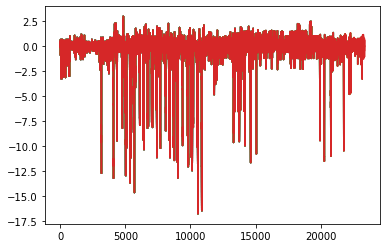

In [78]:
# buffer (15,25) .3 as slope 
debug = True
diff_ls,time_1_ls,time_2_ls = evalAll("temporalRunning9",False)

In [85]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

import sys
import time


DTYPE_INT32 = np.int32
ctypedef np.int32_t DTYPE_INT32_t

DTYPE_FLOAT = np.float64
ctypedef np.float64_t DTYPE_FLOAT_t

cdef DTYPE_FLOAT_t MAX_FLOAT = float('inf')

# careful, without bounds checking can mess up memory - also can't use negative indices I think (like x[-1])
@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_Cost_To_AccumCostAndSteps(Cin, parameter, int est_curr_frame):
    '''
    Inputs
        C: The cost Matrix
    '''
    '''
    Section for checking and catching errors in the inputs
    '''

    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] C
    try:
        C = np.array(Cin, dtype=DTYPE_FLOAT)
    except TypeError:
        print(bcolors.FAIL + "FAILURE: The type of the cost matrix is wrong - please pass in a 2-d numpy array" + bcolors.ENDC)
        return [-1, -1, -1]
    except ValueError:
        print(bcolors.FAIL + "FAILURE: The type of the elements in the cost matrix is wrong - please have each element be a float (perhaps you passed in a matrix of ints?)" + bcolors.ENDC)
        return [-1, -1, -1]

    cdef np.ndarray[np.uint32_t, ndim=1] dn
    cdef np.ndarray[np.uint32_t, ndim=1] dm
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=1] dw
    # make sure dn, dm, and dw are setup
    # dn loading and exception handling
    if ('dn'  in parameter.keys()):
        try:

            dn = np.array(parameter['dn'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dn (row steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "The type of the elements in dn (row steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dn = np.array([1, 1, 0], dtype=np.uint32)
    # dm loading and exception handling
    if 'dm'  in parameter.keys():
        try:
            dm = np.array(parameter['dm'], dtype=np.uint32)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dm (col steps) is wrong - please pass in a 1-d numpy array that holds uint32s" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE: The type of the elements in dm (col steps) is wrong - please have each element be a uint32 (perhaps you passed a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.uint32)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        print(bcolors.FAIL + "dm (col steps) was not passed in (gave default value [1,0,1]) " + bcolors.ENDC)
        dm = np.array([1, 0, 1], dtype=np.uint32)
    # dw loading and exception handling
    if 'dw'  in parameter.keys():
        try:
            dw = np.array(parameter['dw'], dtype=DTYPE_FLOAT)
        except TypeError:
            print(bcolors.FAIL + "FAILURE: The type of dw (step weights) is wrong - please pass in a 1-d numpy array that holds floats" + bcolors.ENDC)
            return [-1, -1, -1]
        except ValueError:
            print(bcolors.FAIL + "FAILURE:The type of the elements in dw (step weights) is wrong - please have each element be a float (perhaps you passed ints or a long?). You can specify this when making a numpy array like: np.array([1,2,3],dtype=np.float64)" + bcolors.ENDC)
            return [-1, -1, -1]
    else:
        dw = np.array([1, 1, 1], dtype=DTYPE_FLOAT)
        print(bcolors.FAIL + "dw (step weights) was not passed in (gave default value [1,1,1]) " + bcolors.ENDC)

    
    '''
    Section where types are given to the variables we're going to use 
    '''
    # create matrices to store our results (D and E)
    cdef DTYPE_INT32_t numRows = C.shape[0] # only works with np arrays, use np.shape(x) will work on lists? want to force to use np though?
    cdef DTYPE_INT32_t est_curr_frame1 = est_curr_frame
    cdef DTYPE_INT32_t numCols = C.shape[1]
    cdef DTYPE_INT32_t numDifSteps = np.size(dw)

    cdef unsigned int maxRowStep = max(dn)
    cdef unsigned int maxColStep = max(dm)

    cdef np.ndarray[np.uint32_t, ndim=2] steps = np.zeros((numRows,numCols), dtype=np.uint32)
    cdef np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost = np.ones((maxRowStep + numRows, maxColStep + numCols), dtype=DTYPE_FLOAT) * MAX_FLOAT

    cdef DTYPE_FLOAT_t bestCost
    cdef DTYPE_INT32_t bestCostIndex
    cdef DTYPE_FLOAT_t costForStep
    cdef unsigned int row, col
    cdef unsigned int stepIndex

    '''
    The start of the actual algorithm, now that all our variables are set up
    '''
    # initializing the cost matrix - depends on whether its subsequence DTW
    # essentially allow us to hop on the bottom anywhere (so could start partway through one of the signals)
    if parameter['SubSequence']:
        est_curr_frame1 = max(min(est_curr_frame1, numCols),0)
        
        
        
        ###################################################################################
        lower_bound = max(est_curr_frame1-15,0)
        upper_bound = min(est_curr_frame1+10,numCols)
        ###################################################################################
        
        
        
        
        
        ### START CODE BLOCK ###
        inf = float("inf")
        accumCost[maxRowStep,maxColStep:maxColStep+lower_bound]=.3*np.arange(lower_bound,0,-1)
        accumCost[maxRowStep,maxColStep+upper_bound:]=.3*np.arange(numCols-upper_bound)
        accumCost[maxRowStep,maxColStep+lower_bound:maxColStep+upper_bound] = 0
    else:
        accumCost[maxRowStep, maxColStep] = C[0,0]
        

    # filling the accumulated cost matrix
    for row in range(maxRowStep, numRows + maxRowStep, 1):
        for col in range(maxColStep, numCols + maxColStep, 1):
            bestCost = accumCost[<unsigned int>row, <unsigned int>col] # initialize with what's there - so if is an entry point, then can start low
            bestCostIndex = 0
            # go through each step, find the best one
            for stepIndex in range(numDifSteps):
                #costForStep = accumCost[<unsigned int>(row - dn[<unsigned int>(stepIndex)]), <unsigned int>(col - dm[<unsigned int>(stepIndex)])] + dw[<unsigned int>(stepIndex)] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                costForStep = accumCost[<unsigned int>((row - dn[(stepIndex)])), <unsigned int>((col - dm[(stepIndex)]))] + dw[stepIndex] * C[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)]
                if costForStep < bestCost:
                    bestCost = costForStep
                    bestCostIndex = stepIndex
            # save the best cost and best cost index
            accumCost[row, col] = bestCost
            steps[<unsigned int>(row - maxRowStep), <unsigned int>(col - maxColStep)] = bestCostIndex

    # return the accumulated cost along with the matrix of steps taken to achieve that cost
    return [accumCost[maxRowStep:, maxColStep:], steps]

@cython.boundscheck(False) # turn off bounds-checking for entire function
def DTW_GetPath(np.ndarray[DTYPE_FLOAT_t, ndim=2] accumCost, np.ndarray[np.uint32_t, ndim=2] stepsForCost, parameter):
    '''

    Parameter should have: 'dn', 'dm', 'dw', 'SubSequence'
    '''

    cdef np.ndarray[unsigned int, ndim=1] dn
    cdef np.ndarray[unsigned int, ndim=1] dm
    cdef np.uint8_t subseq
    # make sure dn, dm, and dw are setup
    if ('dn'  in parameter.keys()):
        dn = parameter['dn']
    else:
        dn = np.array([1, 1, 0], dtype=DTYPE_INT32)
    if 'dm'  in parameter.keys():
        dm = parameter['dm']
    else:
        dm = np.array([1, 0, 1], dtype=DTYPE_INT32)
    if 'SubSequence' in parameter.keys():
        subseq = parameter['SubSequence']
    else:
        subseq = 0

    cdef np.uint32_t numRows
    cdef np.uint32_t numCols
    cdef np.uint32_t curRow
    cdef np.uint32_t curCol
    cdef np.uint32_t endCol
    cdef DTYPE_FLOAT_t endCost

    numRows = accumCost.shape[0]
    numCols = accumCost.shape[1]

    # either start at the far corner (non sub-sequence)
    # or start at the lowest cost entry in the last row (sub-sequence)
    # where all of the signal along the row has been used, but only a 
    # sub-sequence of the signal along the columns has to be used
    curRow = numRows - 1
    if subseq:
        curCol = np.argmin(accumCost[numRows - 1, :])
    else:
        curCol = numCols - 1

    endCol = curCol
    endCost = accumCost[curRow, curCol]

    cdef np.uint32_t curRowStep
    cdef np.uint32_t curColStep
    cdef np.uint32_t curStepIndex


    cdef np.ndarray[np.uint32_t, ndim=2] path = np.zeros((2, numRows + numCols), dtype=np.uint32) # make as large as could need, then chop at the end
    path[0, 0] = curRow
    path[1, 0] = curCol

    cdef np.uint32_t stepsInPath = 1 # starts at one, we add in one before looping
    cdef np.uint32_t stepIndex = 0
    cdef np.int8_t done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)
    while not done:
        if accumCost[curRow, curCol] == MAX_FLOAT:
            print('A path is not possible')
            break

        # you're done if you've made it to the bottom left (non sub-sequence)
        # or just the bottom (sub-sequence)
        # find the step size
        curStepIndex = stepsForCost[curRow, curCol]
        curRowStep = dn[curStepIndex]
        curColStep = dm[curStepIndex]
        # backtrack by 1 step
        curRow = curRow - curRowStep
        curCol = curCol - curColStep
        # add your new location onto the path
        path[0, stepsInPath] = curRow
        path[1, stepsInPath] = curCol
        stepsInPath = stepsInPath + 1
        # check to see if you're done
        done = (subseq and curRow == 0) or (curRow == 0 and curCol == 0)

    # reverse the path (a matrix with two rows) and return it
    return [np.fliplr(path[:, 0:stepsInPath]), endCol, endCost]

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

0 0 0 p1f_perf16 p1s_perf12


result 0 [0, 0, 'p1f_perf16', 'p1s_perf12']
0.9 1.0 1.0

1 0 0 p1f_perf16 p1s_perf2
2 0 0 p1f_perf16 p1s_perf25
3 0 0 p1f_perf16 p1s_perf3
4 0 0 p1f_perf16 p1s_perf9
5 0 0 p1f_perf2 p1s_perf12
6 0 0 p1f_perf2 p1s_perf2
7 0 0 p1f_perf2 p1s_perf25
8 0 0 p1f_perf2 p1s_perf3
9 0 0 p1f_perf2 p1s_perf9
10 0 0 p1f_perf23 p1s_perf12


result 10 [0, 0, 'p1f_perf23', 'p1s_perf12']
0.9333333333333333 0.9848484848484849 0.9939393939393939

11 0 0 p1f_perf23 p1s_perf2
12 0 0 p1f_perf23 p1s_perf25
13 0 0 p1f_perf23 p1s_perf3
14 0 0 p1f_perf23 p1s_perf9
15 0 0 p1f_perf24 p1s_perf12
16 0 0 p1f_perf24 p1s_perf2
17 0 0 p1f_perf24 p1s_perf25
18 0 0 p1f_perf24 p1s_perf3
19 0 0 p1f_perf24 p1s_perf9
20 0 0 p1f_perf6 p1s_perf12


result 20 [0, 0, 'p1f_perf6', 'p1s_perf12']
0.926984126984127 0.9825396825396825 0.9952380952380953

21 0 0 p1f_perf6 p1s_perf2
22 0 0 p1f_perf6 p1s_perf25
23 0 0 p1f_perf6 p1s_perf3
24 0 0 p1f_perf6 p1s_perf9
25 0 1 p1f_perf16 p1s_perf12
26 0 1 p1f_per



result 140 [1, 0, 'p2f_perf20', 'p2s_perf10']
0.8744631003514253 0.9338149160484186 0.9650527137836783

141 1 0 p2f_perf20 p2s_perf17
142 1 0 p2f_perf20 p2s_perf4
143 1 0 p2f_perf20 p2s_perf8
144 1 0 p2f_perf20 p2s_perf9
145 1 0 p2f_perf5 p2s_perf10
1 0 p2f_perf5 p2s_perf10 43
     -5.224565381814061      25.05343915333333 30.278004535147392
1 0 p2f_perf5 p2s_perf10 87
     -5.36331821637188      40.470672713333336 45.833990929705216
1 0 p2f_perf5 p2s_perf10 89
     -5.777762660607706      41.071035525333336 46.84879818594104
1 0 p2f_perf5 p2s_perf10 91
     -6.237414965952383      41.650204081666665 47.88761904761905
1 0 p2f_perf5 p2s_perf10 92
     -6.34955404430839      42.26904006 48.61859410430839
1 0 p2f_perf5 p2s_perf10 94
     -6.935434618312929      42.850687830666665 49.78612244897959
1 0 p2f_perf5 p2s_perf10 96
     -6.655948601922901      43.45606953866667 50.11201814058957
1 0 p2f_perf5 p2s_perf10 98
     -6.928563869929695      44.05808012100001 50.98664399092971
1 0 p2

223 1 3 p2f_perf5 p2s_perf8
224 1 3 p2f_perf5 p2s_perf9
225 1 4 p2f_perf1 p2s_perf10
226 1 4 p2f_perf1 p2s_perf17
227 1 4 p2f_perf1 p2s_perf4
228 1 4 p2f_perf1 p2s_perf8
229 1 4 p2f_perf1 p2s_perf9
230 1 4 p2f_perf14 p2s_perf10


result 230 [1, 4, 'p2f_perf14', 'p2s_perf10']
0.7979779905162387 0.9022098953207479 0.9647490382034535

231 1 4 p2f_perf14 p2s_perf17
232 1 4 p2f_perf14 p2s_perf4
233 1 4 p2f_perf14 p2s_perf8
234 1 4 p2f_perf14 p2s_perf9
235 1 4 p2f_perf18 p2s_perf10
236 1 4 p2f_perf18 p2s_perf17
237 1 4 p2f_perf18 p2s_perf4
238 1 4 p2f_perf18 p2s_perf8
239 1 4 p2f_perf18 p2s_perf9
240 1 4 p2f_perf20 p2s_perf10


result 240 [1, 4, 'p2f_perf20', 'p2s_perf10']
0.7981454451790161 0.9041813342491629 0.966171546320941

241 1 4 p2f_perf20 p2s_perf17
242 1 4 p2f_perf20 p2s_perf4
243 1 4 p2f_perf20 p2s_perf8
244 1 4 p2f_perf20 p2s_perf9
245 1 4 p2f_perf5 p2s_perf10
246 1 4 p2f_perf5 p2s_perf17
247 1 4 p2f_perf5 p2s_perf4
248 1 4 p2f_perf5 p2s_perf8
249 1 4 p2f_perf5 p2s_perf9
250 2 0 

/home/krong/.local/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


2 1 p3f_perf11 p3s_perf12 105
     -5.942842025920631      68.72541194233334 74.66825396825396
2 1 p3f_perf11 p3s_perf12 106
     -5.733348450535156      69.388329554 75.12167800453514
2 1 p3f_perf11 p3s_perf12 108
     -5.920234315972775      69.99792894933334 75.91816326530612
2 1 p3f_perf11 p3s_perf12 110
     -6.333968254165532      70.647482993 76.98145124716554
2 1 p3f_perf11 p3s_perf12 112
     -6.628049886721079      71.25229024933334 77.88034013605443
2 1 p3f_perf11 p3s_perf12 113
     -6.023348450653061      71.89739984866667 77.92074829931973
2 1 p3f_perf11 p3s_perf12 115
     -5.237815570331066      72.50175359066667 77.73956916099773
2 1 p3f_perf11 p3s_perf12 120
     -5.074860165854874      74.37089947133333 79.4457596371882
2 1 p3f_perf11 p3s_perf12 124
     -5.854988662340138      75.59297052133333 81.44795918367348
2 1 p3f_perf11 p3s_perf12 126
     -5.965306122433109      76.186984127 82.15229024943311
2 1 p3f_perf11 p3s_perf12 127
     -6.128148147986395      76.8226

/home/krong/.local/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


2 1 p3f_perf2 p3s_perf12 105
     -6.103567649133793      79.38518518533333 85.48875283446712
2 1 p3f_perf2 p3s_perf12 106
     -6.27501133808844      80.08512471633333 86.36013605442177
2 1 p3f_perf2 p3s_perf12 108
     -6.065600907149664      80.71950113366667 86.78510204081633
2 1 p3f_perf2 p3s_perf12 110
     -6.510325018972783      81.384504913 87.8948299319728
2 1 p3f_perf2 p3s_perf12 112
     -7.638934240208626      81.99070294799999 89.62963718820862
2 1 p3f_perf2 p3s_perf12 113
     -6.243650793757368      82.63691609966666 88.88056689342403
2 1 p3f_perf2 p3s_perf12 115
     -6.7167649283015765      83.25720332566668 89.97396825396825
2 1 p3f_perf2 p3s_perf12 117
     -6.929478458070308      83.90721088433332 90.83668934240363
2 1 p3f_perf2 p3s_perf12 119
     -5.996840514124724      84.54352229766666 90.54036281179138
2 1 p3f_perf2 p3s_perf12 120
     -7.31147392275285      85.19156462599999 92.50303854875284
2 1 p3f_perf2 p3s_perf12 122
     -8.475857898639452      85.818972

/home/krong/.local/lib/python3.7/site-packages/librosa/core/pitch.py:146: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


2 1 p3f_perf24 p3s_perf12 105
     -7.273862434068015      71.59906273600001 78.87292517006803
2 1 p3f_perf24 p3s_perf12 106
     -6.819002267396829      72.31972789133333 79.13873015873016
2 1 p3f_perf24 p3s_perf12 108
     -7.337588813544226      72.96914588033333 80.30673469387754
2 1 p3f_perf24 p3s_perf12 110
     -7.814066515374156      73.61035525333332 81.42442176870749
2 1 p3f_perf24 p3s_perf12 112
     -7.7506651548253975      74.26282690866667 82.01349206349207
2 1 p3f_perf24 p3s_perf12 113
     -6.362562358374158      74.90185941033333 81.26442176870748
2 1 p3f_perf24 p3s_perf12 115
     -7.684323507115644      75.53431594866667 83.21863945578231
2 1 p3f_perf24 p3s_perf12 117
     -7.211821617541947      76.19448223733333 83.40630385487529
2 1 p3f_perf24 p3s_perf12 119
     -7.708571428804999      76.84104308366666 84.54961451247165
2 1 p3f_perf24 p3s_perf12 120
     -8.804807256503398      77.490839002 86.2956462585034
2 1 p3f_perf24 p3s_perf12 122
     -7.688964474927434  

382 3 0 p4f_perf16 p4s_perf9
383 3 0 p4f_perf2 p4s_perf15
384 3 0 p4f_perf2 p4s_perf2
385 3 0 p4f_perf2 p4s_perf8
386 3 0 p4f_perf2 p4s_perf9
387 3 1 p4f_perf13 p4s_perf15
388 3 1 p4f_perf13 p4s_perf2
389 3 1 p4f_perf13 p4s_perf8
390 3 1 p4f_perf13 p4s_perf9


result 390 [3, 1, 'p4f_perf13', 'p4s_perf9']
0.8422472548277168 0.9249337372207497 0.9706550549034456

391 3 1 p4f_perf16 p4s_perf15
392 3 1 p4f_perf16 p4s_perf2
393 3 1 p4f_perf16 p4s_perf8
394 3 1 p4f_perf16 p4s_perf9
395 3 1 p4f_perf2 p4s_perf15
396 3 1 p4f_perf2 p4s_perf2
397 3 1 p4f_perf2 p4s_perf8
398 3 1 p4f_perf2 p4s_perf9
399 3 2 p4f_perf13 p4s_perf15
400 3 2 p4f_perf13 p4s_perf2


result 400 [3, 2, 'p4f_perf13', 'p4s_perf2']
0.8455210237659964 0.9271480804387568 0.9716636197440585

401 3 2 p4f_perf13 p4s_perf8
402 3 2 p4f_perf13 p4s_perf9
403 3 2 p4f_perf16 p4s_perf15
404 3 2 p4f_perf16 p4s_perf2
405 3 2 p4f_perf16 p4s_perf8
406 3 2 p4f_perf16 p4s_perf9
407 3 2 p4f_perf2 p4s_perf15
408 3 2 p4f_perf2 p4s_perf2
409 3 2 p4

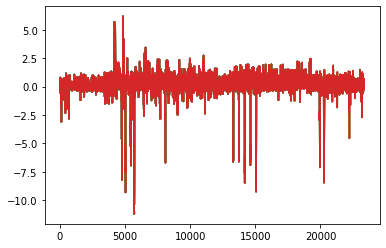

In [89]:
# Adjust buffer based on previous graph. buffer:(15,10) slope:.3. Unclear explanation yet 
# One intuition is that the stablizing effect of historical data improves precision so we prefer a 
# smaller buffer zone. Not sure why current index is so head comparatively though.
debug = False
diff_ls,time_1_ls,time_2_ls = evalAll("temporalRunning12",False)

Text(0, 0.5, 'Accuracy')

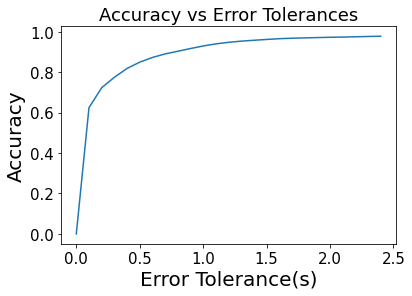

In [92]:
plt.title("Accuracy vs Error Tolerances")
incr, length = .1, 25
x_axis = np.arange(0,length)*incr
y_axis = np.array([np.sum(np.where(np.abs(diff_ls)<incr*i+.000000001,1,0))/len(diff_ls) for i in range(length)])
plt.plot(x_axis,y_axis)
plt.xlabel('Error Tolerance(s)', fontsize=20)
plt.ylabel('Accuracy', fontsize=20)